---

<h1 style="text-align:center"> Machine Learning Project 21/22 - Survival Prediction of Patients</h1>
<h5 style="text-align:center"> Danilo Dell'Orco - Michele Salvatori - Jacopo Fabi </h5>

---

# Introduzione

L'obiettivo è quello di utilizzare il dataset [Patient Survival Prediction](https://www.kaggle.com/datasets/mitishaagarwal/patient) per effettuare il training diversi classificatori, al fine di predirre se un paziente sopravvivrà o morirà sulla base dei *parametri vitali* registrati al momento dell'ingresso in ospedale. Per fare ciò si effettua innanzitutto una fase di **Data Exploration**, in modo da ricavare informazioni utili sui dati da utilizzare, e comprendere quali sono le feature probabilmente più rilevanti ai fini della classificazione. Dopo aver splittato il dataset in **Testing e Training Set**, si procede conj l'**Ingegneria delle Features** sul Training Set, rimuovendo le features con *valori nulli*, *poco correlate* con il target, ed applicando la *feature selection*. Successivamente si esegue una fase di **Model Selection** sui vari classificatori considerati, effettuando il *tuning dei loro iperparametri*. Infine, si eseguono tutti i **Classificatori** con le features ed i parametri individuati in precedenza, effettuando un confronto tra le prestazioni ottenute.

## Indice

- **Operazioni Preliminari**
    - Installazione dipendenze
    - Import delle Librerie
    - Caricamento del sataset
    - Funzioni e variabili user-defined
    $$$$
- **Data Exploration**
    - Descrizione del Dataset
    - Bilanciamento delle classi
    - Distribuzione delle Features
    - Visualizzazione campi non nulli
    - Conversione Features e Mapping
    - Correlazione tra le Features
    - Analisi delle Features
    $$$$
- **Criterio di Performance Evaluation**
    - Training & Test Splitting
    - Scelta della Metrica
    - Risultati sul Dataset originale
    $$$$
- **Features Engineering**
    - Rimozione features con valori nulli
    - Rimozione features con bassa varianza
    - Rimozione features con bassa correlazione col target
    - Feature Selection
    - Confronto Prestazioni
    - Imputazione dei dati mancanti
    - Altri tentativi di Miglioramento
        - SMOTE
    $$$$
- **Model Selection** e **Classificazione**
    - Logistic Regression Classifier
    - Decision Tree Classifier
    - Naive Bayes Classifier
    - Random Forest Classifier
    - AdaBoost Classifier
    - Linear Discriminant Analysis
    - Support Vector Machine
    - KNeighbors Classsifier
    - MLP Classifier
    $$$$
- **Contronto e Conclusioni**


# Operazioni Preliminari

Descriviamo le operazioni preliminari, necessarie per l'esecuzione delle varie celle nel notebook.

### Installazione Dipendenze

Prima di eseguire l'import delle librerie, è necessario che tutte queste siano installate sulla macchina locale. Per questo nel file `requirements` sono specificate tutte le dipendenze necessarie, facilmente installabili lanciando dalla directory del progetto il comando:

```
pip install -r requirements
```

### Import delle Librerie

In [1]:
# Dataframe & Plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Processing
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Altri import
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('always')

### Caricamento del Dataset

Caricamento del dataset `csv` in `Dataframe` tramite `pandas`

In [2]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
print(dataset.shape)
dataset.head()

(91713, 85)


encounter_id  patient_id  hospital_id   age    bmi  elective_surgery  \
0         66154       25312          118  68.0  22.73                 0   
1        114252       59342           81  77.0  27.42                 0   
2        119783       50777          118  25.0  31.95                 0   
3         79267       46918          118  81.0  22.64                 1   
4         92056       34377           33  19.0    NaN                 0   

   ethnicity gender  height           icu_admit_source  ...  \
0  Caucasian      M   180.3                      Floor  ...   
1  Caucasian      F   160.0                      Floor  ...   
2  Caucasian      F   172.7       Accident & Emergency  ...   
3  Caucasian      F   165.1  Operating Room / Recovery  ...   
4  Caucasian      M   188.0       Accident & Emergency  ...   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  \
0                          0.0                Sepsis       Cardiovascular   
1                          0.0           Respiratory          Respiratory   
2                          0.0             Metabolic            Metabolic   
3                          0.0        Cardiovascular       Cardiovascular   
4                          0.0                Trauma               Trauma   

   Unnamed: 83  hospital_death  
0          NaN               0  
1          NaN               0  
2          NaN               0  
3          NaN               0  
4          NaN               0  

[5 rows x 85 columns]

### Funzioni e variabili user-defined

Effettuiamo la definizione di tutte le funzioni utilizzate nel notebook.

In [3]:
global trainX                   # Righe del training set
global testX                    # Righe del testing set
global trainY                   # Colonna target del training set
global testY                    # Colonna target del testing set
global important_features       # Lista delle feature individuate nell'analisi preliminare
global correlation_matrix       # Matrice di correlazione tra le features

global trainX_og                # Mantiene una copia del training set originale, per il confronto delle prestazioni dopo la feature selection
global testX_og                 # Mantiene una copia del testing set originale, per il confronto delle prestazioni dopo la feature selection
global scores_dict              # Dizionario che mantiene tutti i risultati delle classificazioni effettuate

global scores_original          # Dataframe che mantiene i risultati della classificazioni sul dataset originale
global scores                   # Dataframe che mantiene i risultati delle classificazioni dopo la feature selection


important_features = []
scores_dict = {}

In [4]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Rimuove le features columns_list specificate dal training set
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def drop_features_from_trainset(columns_list):
    global trainX,testX
    trainX_tmp = trainX.copy()
    trainX = trainX.drop(columns=columns_list)
    testX = testX.drop(columns=columns_list)

    if (len(trainX_tmp.columns) - len(trainX.columns)) != 0:
        print ("Training Set Updated:",trainX_tmp.shape,"->",trainX.shape)
    else:
        print ("No features dropped!")
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ottiene la lista di features con correlazione rispetto al target inferiore alla threshold specificata
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def get_low_correlated_features(threshold):
    td = []
    for feature in trainX.columns:
        ind = trainX.columns.get_loc(feature)
        target_corr = correlation_matrix.values[-1][ind]
        if (target_corr>=-threshold and target_corr<0) or (target_corr<=threshold and target_corr>0):
            td.append(feature)
    return td
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ottiene la percentuale di valori nulli per ogni feature del dataset, ritornando quelle colonne cui %NaN supera una certa threshold
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def plot_nas(datasetX, use_threshold=False, threshold=None):
    to_delete = []
    if datasetX.isnull().sum().sum() != 0:
        na_datasetX = (datasetX.isnull().sum() / len(datasetX)) * 100
        na_datasetX = na_datasetX.drop(na_datasetX[na_datasetX == 0].index).sort_values(ascending=False)
        to_delete = na_datasetX[na_datasetX > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_datasetX})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,20)

        if use_threshold:
            plt.axvline(x=threshold, color='red')
        plt.show()
        
    else:
        print('No NaNs found')
        return None
    
    if use_threshold:
        print(to_delete.index.tolist())
    return to_delete.index.tolist()
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Mostra la matrice di confusione a seguito della classificazione
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def show_confusion_matrix(cm,model_name):
    x_axis_labels = ["Dead", "Survived"]
    y_axis_labels = ["Dead", "Survived"]
    f, ax = plt.subplots(figsize =(7,7))
    sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")
    plt.title('Confusion Matrix for {}'.format(model_name))
    plt.show()
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Aggiunge i risultati di un classificatore al dizionario globale dei risultati.
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def add_score(model_name,experiment,conf_matrix, report):
    TP,FN,FP,TN = conf_matrix.ravel()
    
    scores_dict[model_name] = {
        'Precision' : report['1']['precision'],
        'Accuracy' : report['accuracy'],

        'TPR (recall)': TP/(TP+FN),
        'FNR': FN/(TP+FN),   
        'TNR': TN/(TN+FP),
        'FPR': FP/(TN+FP),

        'experiment' : experiment
    }
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Esegue i tre classificatori usati per il benchmark, oppure un modello specifico se indicato esplicitamente tra i parametri.
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def run_classifications(tr_x,train_Y,te_x,test_Y,fill=None,model=None,model_name=None,experiment=None,show_report=False):
    train_X = tr_x.copy()
    test_X = te_x.copy()

    if fill:
        train_X = train_X.fillna(-1)
    
    test_X = test_X.fillna(-1)
    
    if model == None:
        lrc = LogisticRegression(solver="liblinear")
        rdt = DecisionTreeClassifier()
        gnb = GaussianNB()

        models = [(lrc, "Logistic Regression Classifier"),
                  (rdt, "Decision Tree Classifier"),
                  (gnb, "Gaussian Naive Bayes Classifier")]
    else:
        models = [(model,model_name)]

    for model in models:
        model[0].fit(train_X, train_Y)
        predicted = model[0].predict(test_X)
        report = classification_report(test_Y,predicted,output_dict=True)
        cm = confusion_matrix(test_Y, predicted, labels =[1, 0])
        add_score(model[1],experiment,cm,report)
        if show_report:
            report_print = classification_report(test_Y,predicted)
            print(model[1], "report: \n\n", report_print)
            show_confusion_matrix(cm,model[1])
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Esegue la feature selection tramite Backward Regression, ritornando le colonne selezionate e rimosse dalle features
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def backward_feature_selection():
    global trainX, trainY 
    selector = RFE(estimator = DecisionTreeClassifier() ,step=1)
    selector = selector.fit(trainX.fillna(-1), trainY.fillna(-1))
    rfe_mask = selector.get_support()
    selected = [] 
    removed = []

    for bool, feature in zip(rfe_mask, trainX.columns):
        if bool:
            selected.append(feature)
        else:
            removed.append(feature)

    return selected,removed

# Data Exploration

Nella fase di data exploration andiamo ad analizzare il dataset a disposizione, cercando di ricavare informazioni utili e migliorare la conoscenza sul dominio di interesse.

## Descrizione del Dataset

Il dataset riporta parametri vitali di $91713$ pazienti al momento dell'ingresso in ospedale, come ad esempio peso, età, presenza di malattie gravi, o vari indici di [Apache Scoring](https://pubmed.ncbi.nlm.nih.gov/11579607/). Per ogni paziente, viene inoltre riportato se al termine del trattamento questo è sopravvissuto o deceduto. L'obiettivo dei classificatori allenati su questo dataset, è quindi quello di predirre in base ai parametri di un paziente se questo è in pericolo di vita oppure no.

La classe target è dunque ```hospital_death```, che è rappresentata con un valore binario:
- `0` se il paziente è sopravvissuto.
- `1` se il paziente è deceduto.

Si considera come **positivo** la classe `1`, in quanto si è più interessati a predirre se un paziente morirà . Considerando il dominio di interesse, si assume quindi che un *falso negativo sia un errore più grave rispetto ad un falso positivo*. Questo perché in uno scenario reale risulta molto più pericoloso sottostimare il problema (paziente grave, ma si predice che sopravvivrà), rispetto all'essere più pessimisti (paziente che sopravvive, ma si predice che non sopravvirà).

## Bilanciamento delle Classi

Vogliamo visualizzare il livello di bilanciamento del dataset rispetto alla classe target `hospital_death`. Utilizziamo quindi un `pieplot` per graficare il totale di istanze positive e negative

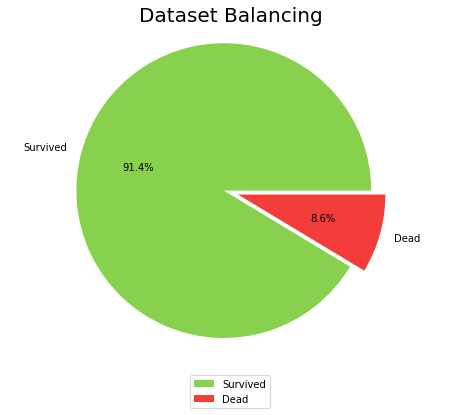

In [5]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
patients = [total_e, total_p]
patients_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(patients,labels=patients_labels,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'], explode=[0.05,0.05])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(patients_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Come possiamo vedere il dataset è **altamente sbilanciato**. Infatti abbiamo il $91.4\%$ di righe che riportano dati per un paziente sopravvissuto, mentre solo l'$8.6\%$ di dati per un paziente deceduto. Ciò implica dire che qualsiasi modello allenato su tale dataset tenderà maggiormente a classificare un'istanza come `survived`, aspettandoci quindi un maggior numero di falsi negativi (`death` classificati erroneamente come `survived`).

Occorre osservare come tale sbilanciamento non è dovuto ad una scarsa qualità del dataset o mancanza di dati raccolti, ma intrinseco nella natura del problema analizzato; infatti considerando un insieme di ospedale è atteso che il numero di pazienti che sopravvivono sia di molto superiore al numero di decessi.

## Distribuzione delle Features

Andiamo a visualizzare la distribuzione delle features all'interno del dataset, riportando in un barplot le variabili categoriche e in un histplot le variabili numeriche.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

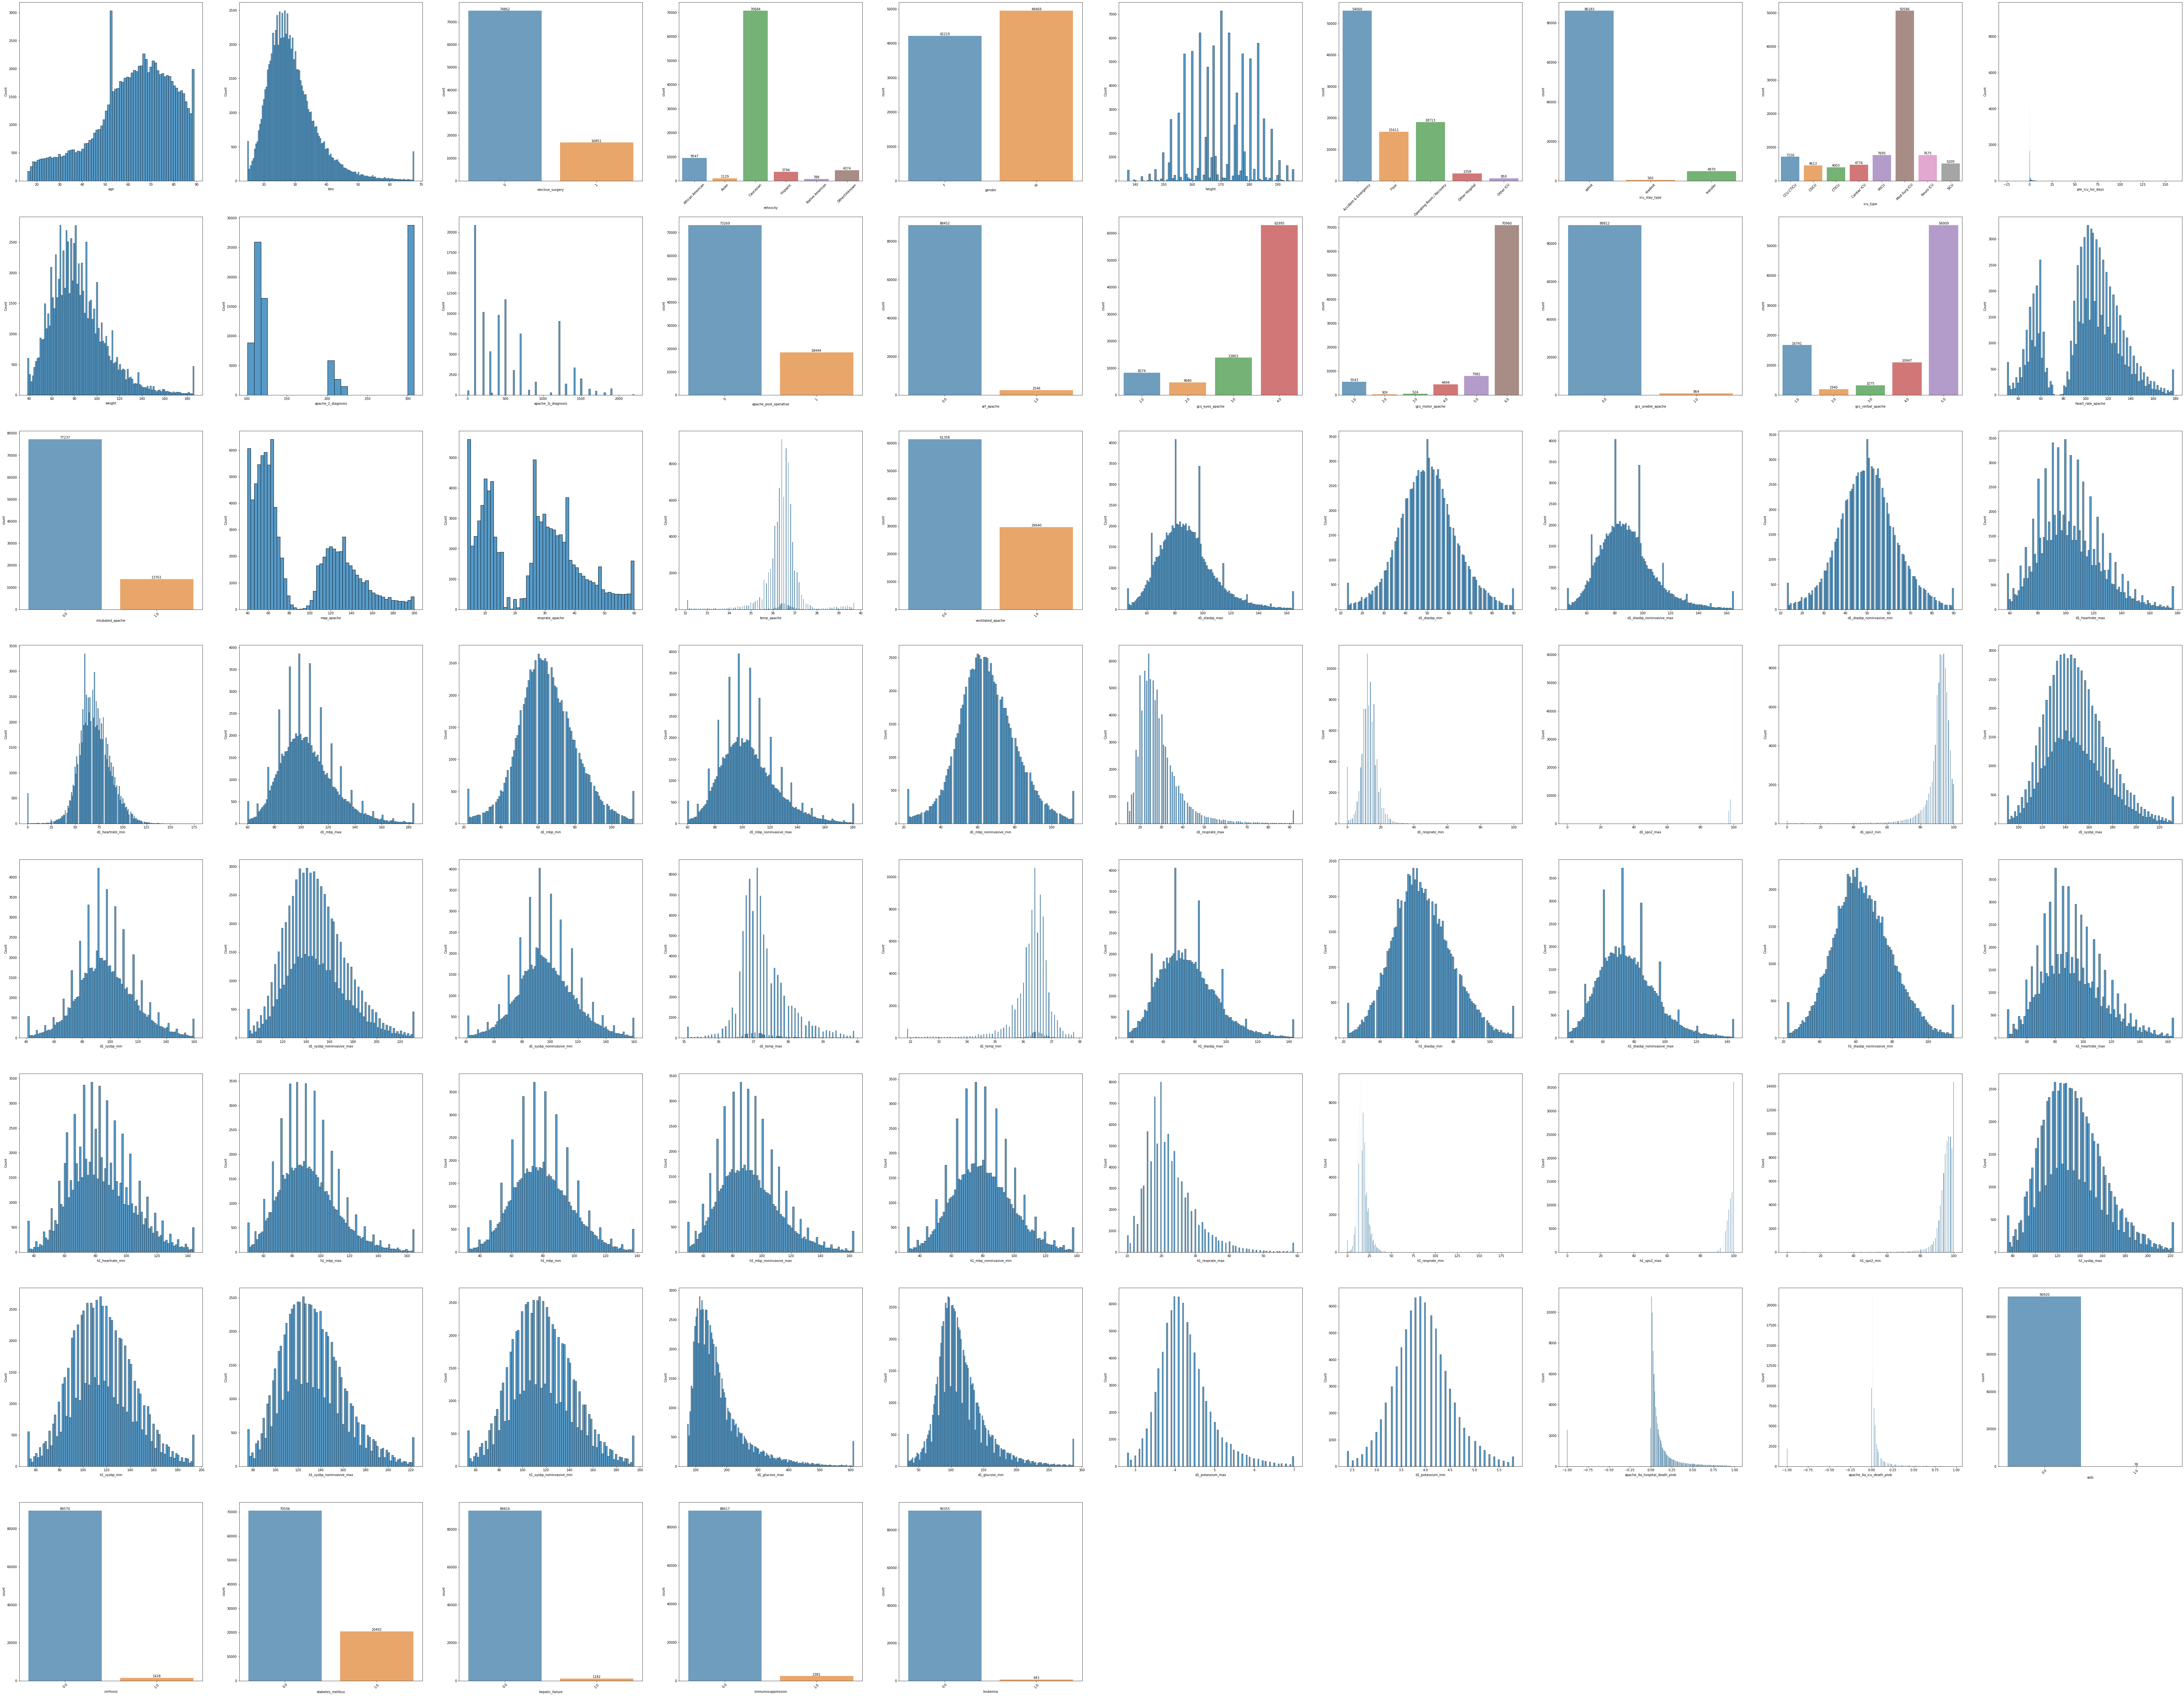

In [7]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
ignore = ['encounter_id','patient_id','Unnamed: 83','hospital_id','icu_id','hospital_death']
categ = []
numer = []

for col in dataset.drop(columns=ignore): 
    dt = dataset[col].dtype
    if dt == "object":
        categ.append(col)
    elif dt == "float64":
        if dataset[col].dropna().nunique()<10:
            dataset[col] = dataset[col].astype('object')
            categ.append(col)
        else:
            numer.append(col)
    elif dt == "int64":
        dataset[col] = dataset[col].astype('object')
        categ.append(col)

fig = plt.figure(figsize=(120,120))
j=1
a=0
b=0
for i in range(0, len(dataset.columns)-len(ignore)):
    col = dataset.columns[i]

    if col in categ:
        fig.add_subplot(10,10,j)
        ax = sns.countplot(x=categ[a], data=dataset, alpha=.7, order=sorted(dataset[col].dropna().unique().tolist(),key=str))
        ax.bar_label(ax.containers[0])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
        j += 1
        a += 1

    elif col in numer:
        fig.add_subplot(10,10,j)
        sns.histplot(dataset[numer[b]].dropna(), kde_kws={"lw": 2, "color":colors[8]})
        j += 1
        b += 1

Possiamo osservare come la maggior parte delle variabili numeriche abbiano una distribuzione che tende ad una normale.

## Visualizzazione campi non nulli

Andiamo a visualizzare la percentuale di campi nulli presenti per ogni colonna *(feature)* del dataset. Questo risulta utile visualizzare eventuali colonne con pochi dati utili,e che possono quindi essere escluse ai fini del training

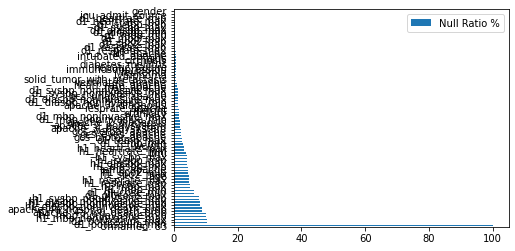

In [8]:
p = plot_nas(dataset)

Analizzando la quantità di valori nulli sulle varie features possiamo vedere come il dataset sia di buona qualità, avendo pochi campi non nulli nelle varie colonne. L'unica eccezione riguarda la feature ```Unnamed: 83```, che presenta esclusivamente campi nulli, e quindi verrà eliminata in una successiva fase di *pulizia del dataset*.

Le restanti features presentano valori `NaN` per una percentuale sempre inferiore al $20\%$, motivo per cui possiamo procedere con il *filling* o l'*imputazione* di tali dati, senza introdurre un rumore eccessivo sui dati. 

## Conversione Features e Mapping

Si effettua la conversione delle features *categoriche* in *ordinali*, mappando ogni ```object``` identificato da una *stringa*, in un altro ```object``` identificato da un *numero*. Il dizionario ```mapping``` mantiene la corrispondenza in modo da poter sempre risalire al nome della label a partire dall'intero assegnatoli.

In [9]:
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
mapping = []

for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):
            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)

for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Visualizziamo il mapping effettuato delle variabili categoriche.
- Si mantengono i valori `NaN` per una successiva fase di imputaizone.
- *NOTA*: I valori `NaN` risultano mappati nel dizionario, ma tramite la clausola `where(~dataset.isna(), dataset)` vengono ristabiliti i valori `NaN` presenti nel dataset originale.

In [10]:
print(mapping)
mapped_dataset.info()

[{0: 0, 1: 1}, {0: 'African American', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Native American', 5: 'Other/Unknown', 6: nan}, {0: 'F', 1: 'M', 2: nan}, {0: 'Accident & Emergency', 1: 'Floor', 2: 'Operating Room / Recovery', 3: 'Other Hospital', 4: 'Other ICU', 5: nan}, {0: 'admit', 1: 'readmit', 2: 'transfer'}, {0: 'CCU-CTICU', 1: 'CSICU', 2: 'CTICU', 3: 'Cardiac ICU', 4: 'MICU', 5: 'Med-Surg ICU', 6: 'Neuro ICU', 7: 'SICU'}, {0: 0, 1: 1}, {0: 0.0, 1: 1.0, 2: nan}, {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: nan}, {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 6.0, 6: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 0.0, 1: 1.0, 2: nan}, {0: 'Cardiovascular', 1: 'Gastrointestinal', 2: 'Genitourinary', 3: 'Gynecological', 4:

## Correlazione tra le Features

Analizziamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia **altamente correlata** con il target (quindi che il suo valore sia importante per discriminare se il paziente sopravvive o muore). Si utilizza a tale scopo l'**indice di Pearson**, in cui si ha un valore compreso tra $(-1,+1)$:
- $-1$ corrisponde alla perfetta correlazione lineare positiva.
- $0$ corrisponde a un'assenza di correlazione lineare.
- $-1$ corrisponde alla perfetta correlazione lineare negativa.

In [11]:
correlation_matrix = mapped_dataset.drop(columns="Unnamed: 83").corr()

Mostriamo la matrice di correlazione

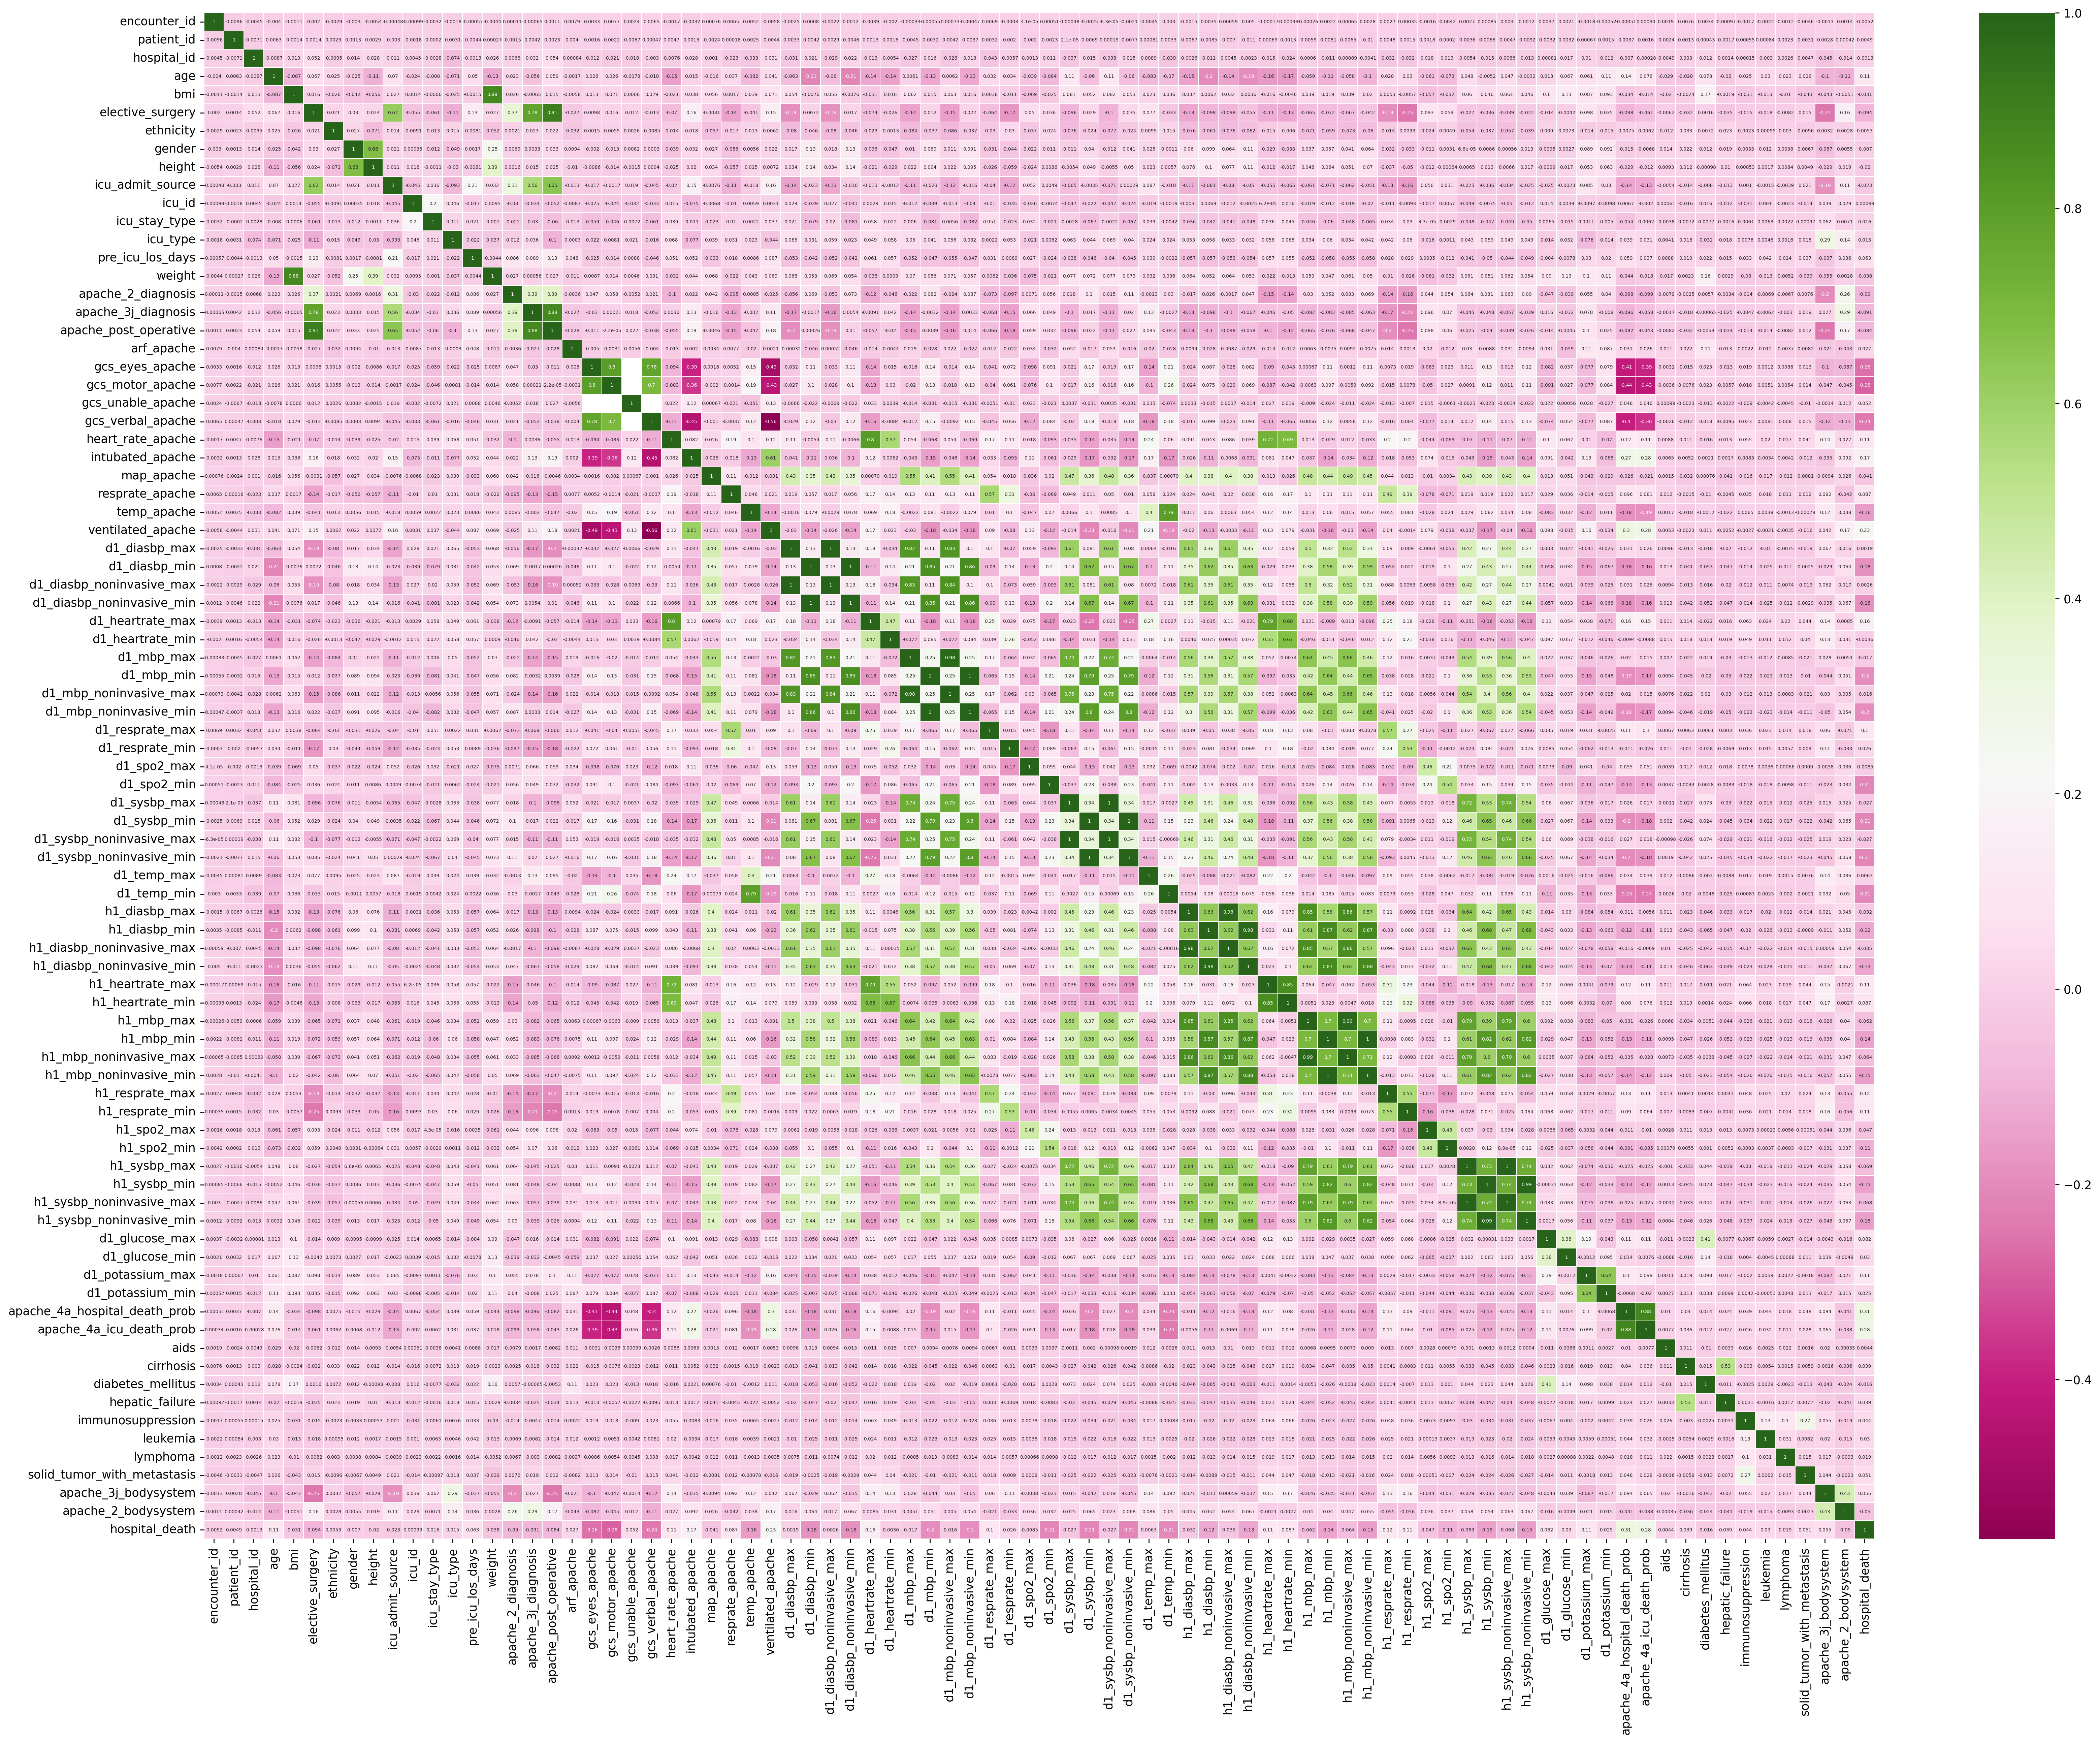

In [12]:
plt.figure(figsize=(32,24), dpi = 250)
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG", annot=True, annot_kws={"fontsize":4})
plt.yticks(rotation=0)
plt.show()

## Analisi delle Features

Analizziamo l'impatto di alcune features rispetto al valore del target. In questo modo dall'analisi del dominio si possono individuare le features che risultano rilevanti ai fini della classificazione, e che vogliamo necessariamente mantenere anche a seguito della riduzione della dimensionalità.

### Probabilità di morte in relazione all'età

Visualizziamo la probabilità di decesso in relazione all'età dei pazienti, distinguendo due casi in base al genere `maschio` o `femmina`

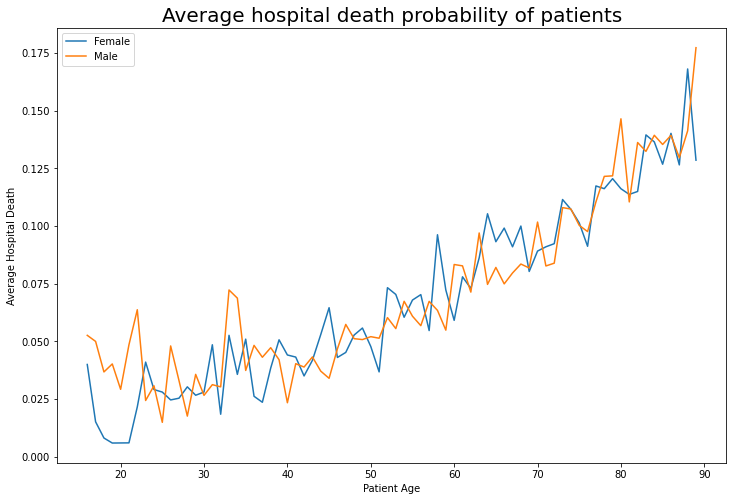

In [13]:
age_death_F=dataset[dataset['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=dataset[dataset['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=age_death_F['age'], y=age_death_F['hospital_death'])
sns.lineplot(x=age_death_M['age'], y=age_death_M['hospital_death'])
plt.title("Average hospital death probability of patients", fontsize = 20)

plt.legend(['Female',"Male"])
plt.xlabel("Patient Age")
plt.ylabel("Average Hospital Death")
fig.show()

Come atteso, l'età risulta essere un fattore determinante nella mortalità dei pazienti ricoverati, ed infatti si può notare un incremento della mortalità con l'avanzare dell'età. Inoltre si può anche osservare come il genere non risulta rilevante nella probabilità di morte, in quanto si può osservare un andamento simile tra maschi e femmine.

In [14]:
important_features.append('age')

### Probabilità di morte in relazione all'etnia

Vogliamo verificare se l'etnia di un paziente ha un impatto sulla probabilità di morte.

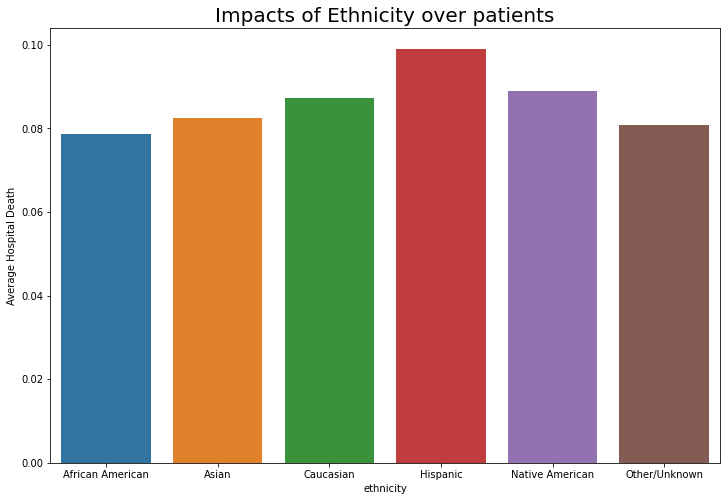

In [15]:
df=dataset[['hospital_death','ethnicity']]

ethnicity_death=df[['ethnicity','hospital_death']].groupby('ethnicity').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.barplot(x=ethnicity_death['ethnicity'], y=ethnicity_death['hospital_death'])
plt.title("Impacts of Ethnicity over patients", fontsize = 20)

plt.xlabel("ethnicity")
plt.ylabel("Average Hospital Death")
fig.show()

Come possiamo vedere la probabilità di morte risulta simile tra tutte le etnie. La feature `ethnicity` non è quindi da considerarsi importante ai fini della classificazione, e verrà ulteriormente analizzata nella fase di *feature Engineering*.

### Probabilità di morte in relazione al BMI

Vogliamo visualizzare l'impatto dell'*Indice di Massa Corporea* sulla probabilità dei pazienti. 

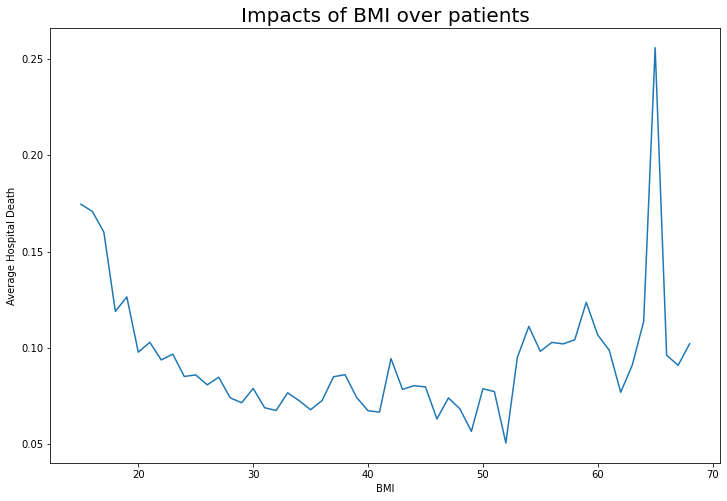

In [16]:
df=dataset[['hospital_death','bmi']]

df['bmi'] = df['bmi'].round(0)
bmi_death=df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=bmi_death['bmi'], y=bmi_death['hospital_death'])
plt.title("Impacts of BMI over patients", fontsize = 20)

plt.xlabel("BMI")
plt.ylabel("Average Hospital Death")
fig.show()

Il BMI impatta notevolmente nella mortalità, infatti un valore troppo basso ($<20$, gravemente sottopeso) o troppo alto ($>50$, obesità di terzo grado) aumenta la probabilità di decesso.  

In [17]:
important_features.append('bmi')

### Probabilità di morte in relazione a score apache

Gli score apache misurano parametri vitali critici, quindi che discriminano fortemente la probabilità di sopravvivenza di un paziente. Andiamo a graficare quindi l'impatto di tali indici sulla probabilità di decesso.

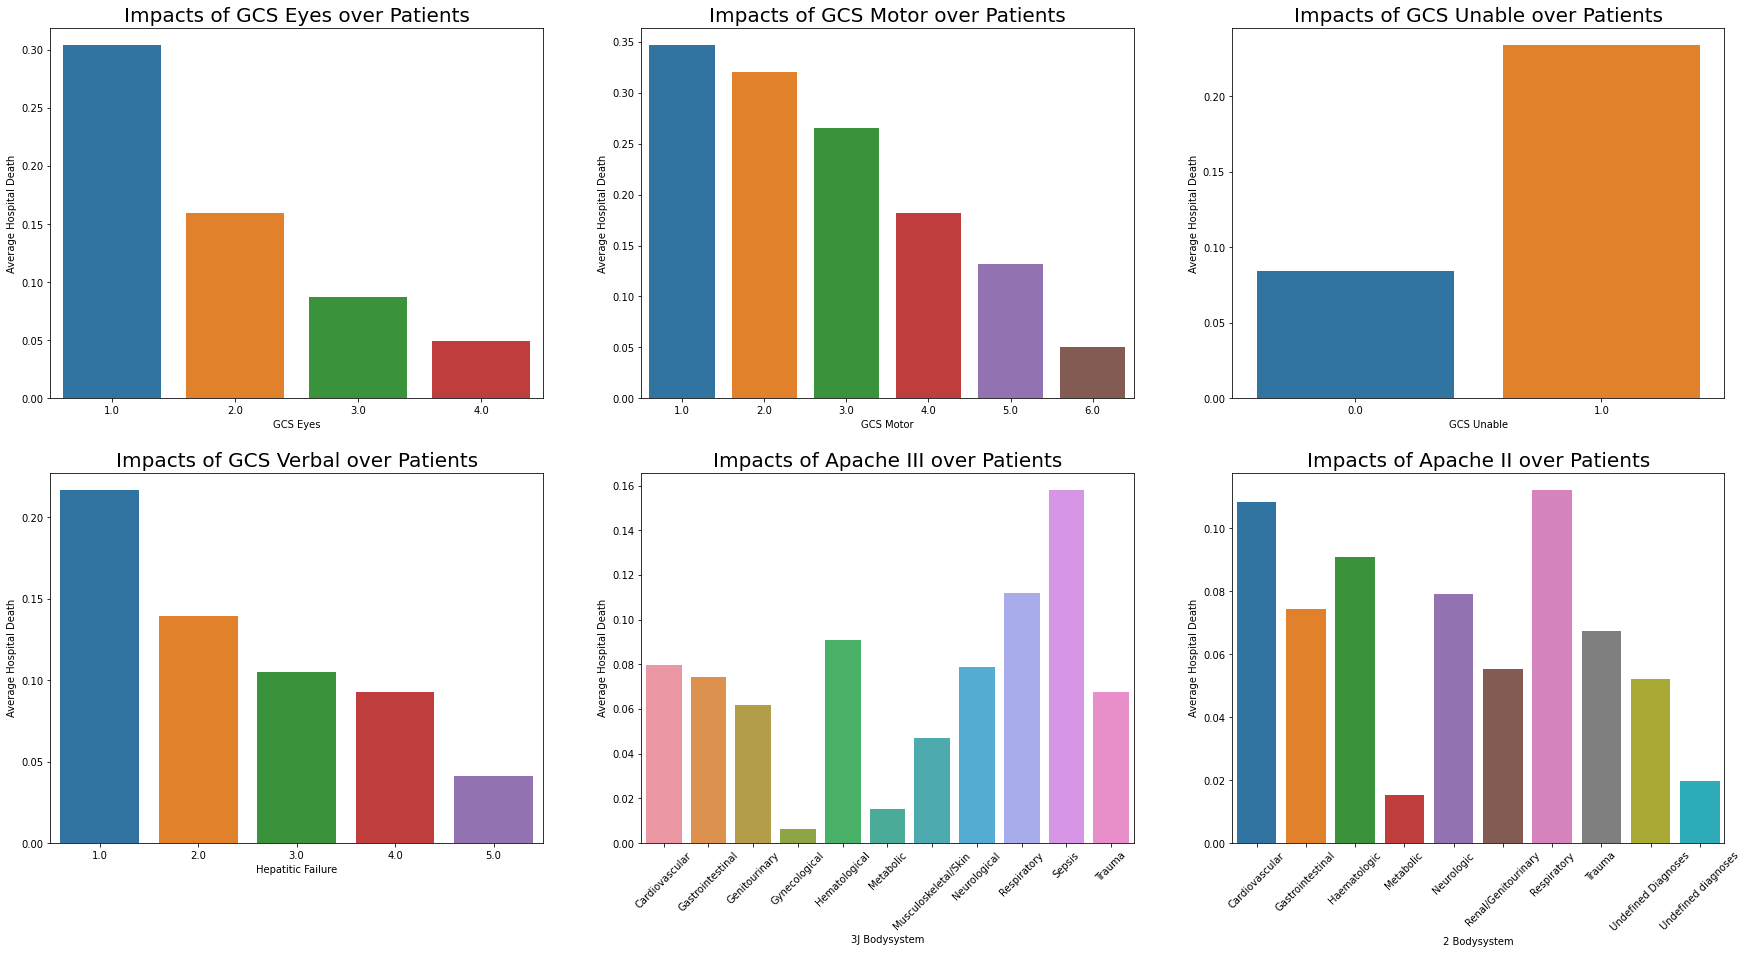

In [18]:
critical = ['hospital_death','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','apache_3j_bodysystem','apache_2_bodysystem']
df=dataset[critical]

gcs_eyes_apache_death=df[['gcs_eyes_apache','hospital_death']].groupby('gcs_eyes_apache').mean().reset_index()
gcs_motor_apache_death=df[['gcs_motor_apache','hospital_death']].groupby('gcs_motor_apache').mean().reset_index()
gcs_unable_apache_death=df[['gcs_unable_apache','hospital_death']].groupby('gcs_unable_apache').mean().reset_index()
gcs_verbal_apache_death=df[['gcs_verbal_apache','hospital_death']].groupby('gcs_verbal_apache').mean().reset_index()
apache_3j_bodysystem_death=df[['apache_3j_bodysystem','hospital_death']].groupby('apache_3j_bodysystem').mean().reset_index()
apache_2_bodysystem_death=df[['apache_2_bodysystem','hospital_death']].groupby('apache_2_bodysystem').mean().reset_index()


fig = plt.figure(figsize=(30,15))

fig.add_subplot(2,3,1)
sns.barplot(x=gcs_eyes_apache_death['gcs_eyes_apache'], y=gcs_eyes_apache_death['hospital_death'])
plt.title("Impacts of GCS Eyes over Patients", fontsize = 20)
plt.xlabel("GCS Eyes")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,2)
sns.barplot(x=gcs_motor_apache_death['gcs_motor_apache'], y=gcs_motor_apache_death['hospital_death'])
plt.title("Impacts of GCS Motor over Patients", fontsize = 20)
plt.xlabel("GCS Motor")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,3)
sns.barplot(x=gcs_unable_apache_death['gcs_unable_apache'], y=gcs_unable_apache_death['hospital_death'])
plt.title("Impacts of GCS Unable over Patients", fontsize = 20)
plt.xlabel("GCS Unable")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,4)
sns.barplot(x=gcs_verbal_apache_death['gcs_verbal_apache'], y=gcs_verbal_apache_death['hospital_death'])
plt.title("Impacts of GCS Verbal over Patients", fontsize = 20)
plt.xlabel("Hepatitic Failure")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,5)
ax = sns.barplot(x=apache_3j_bodysystem_death['apache_3j_bodysystem'], y=apache_3j_bodysystem_death['hospital_death'])
plt.title("Impacts of Apache III over Patients", fontsize = 20)
plt.xlabel("3J Bodysystem")
plt.ylabel("Average Hospital Death")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

fig.add_subplot(2,3,6)
ax = sns.barplot(x=apache_2_bodysystem_death['apache_2_bodysystem'], y=apache_2_bodysystem_death['hospital_death'])
plt.title("Impacts of Apache II over Patients", fontsize = 20)
plt.xlabel("2 Bodysystem")
plt.ylabel("Average Hospital Death")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

fig.show()

warnings.filterwarnings('always')

Vediamo come nel caso degli score *GCS*, per i valori critici (più bassi) si hanno sempre probabilità più alte di decesso. Invece per gli indici di Bodysystem possiamo vedere come diagnosi differenti abbiano probabilità di decesso differenti. Ad esempio la *setticemia* o *complicanze respiratorie* sono più fatali rispetto a casi ginecologici o metabolici.

Questo ci indica dunque come gli score Apache risultano fondamentali ai fini della classificazione.

In [19]:
important_features.extend(['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','apache_3j_bodysystem','apache_2_bodysystem'])

### Probabilità di morte in relazione a malattie gravi

Visualizziamo l'impatto di differenti malattie gravi rispetto alla probabilità di decesso di un paziente.

C:\Users\danil\AppData\Local\Temp\ipykernel_10740\3161860670.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


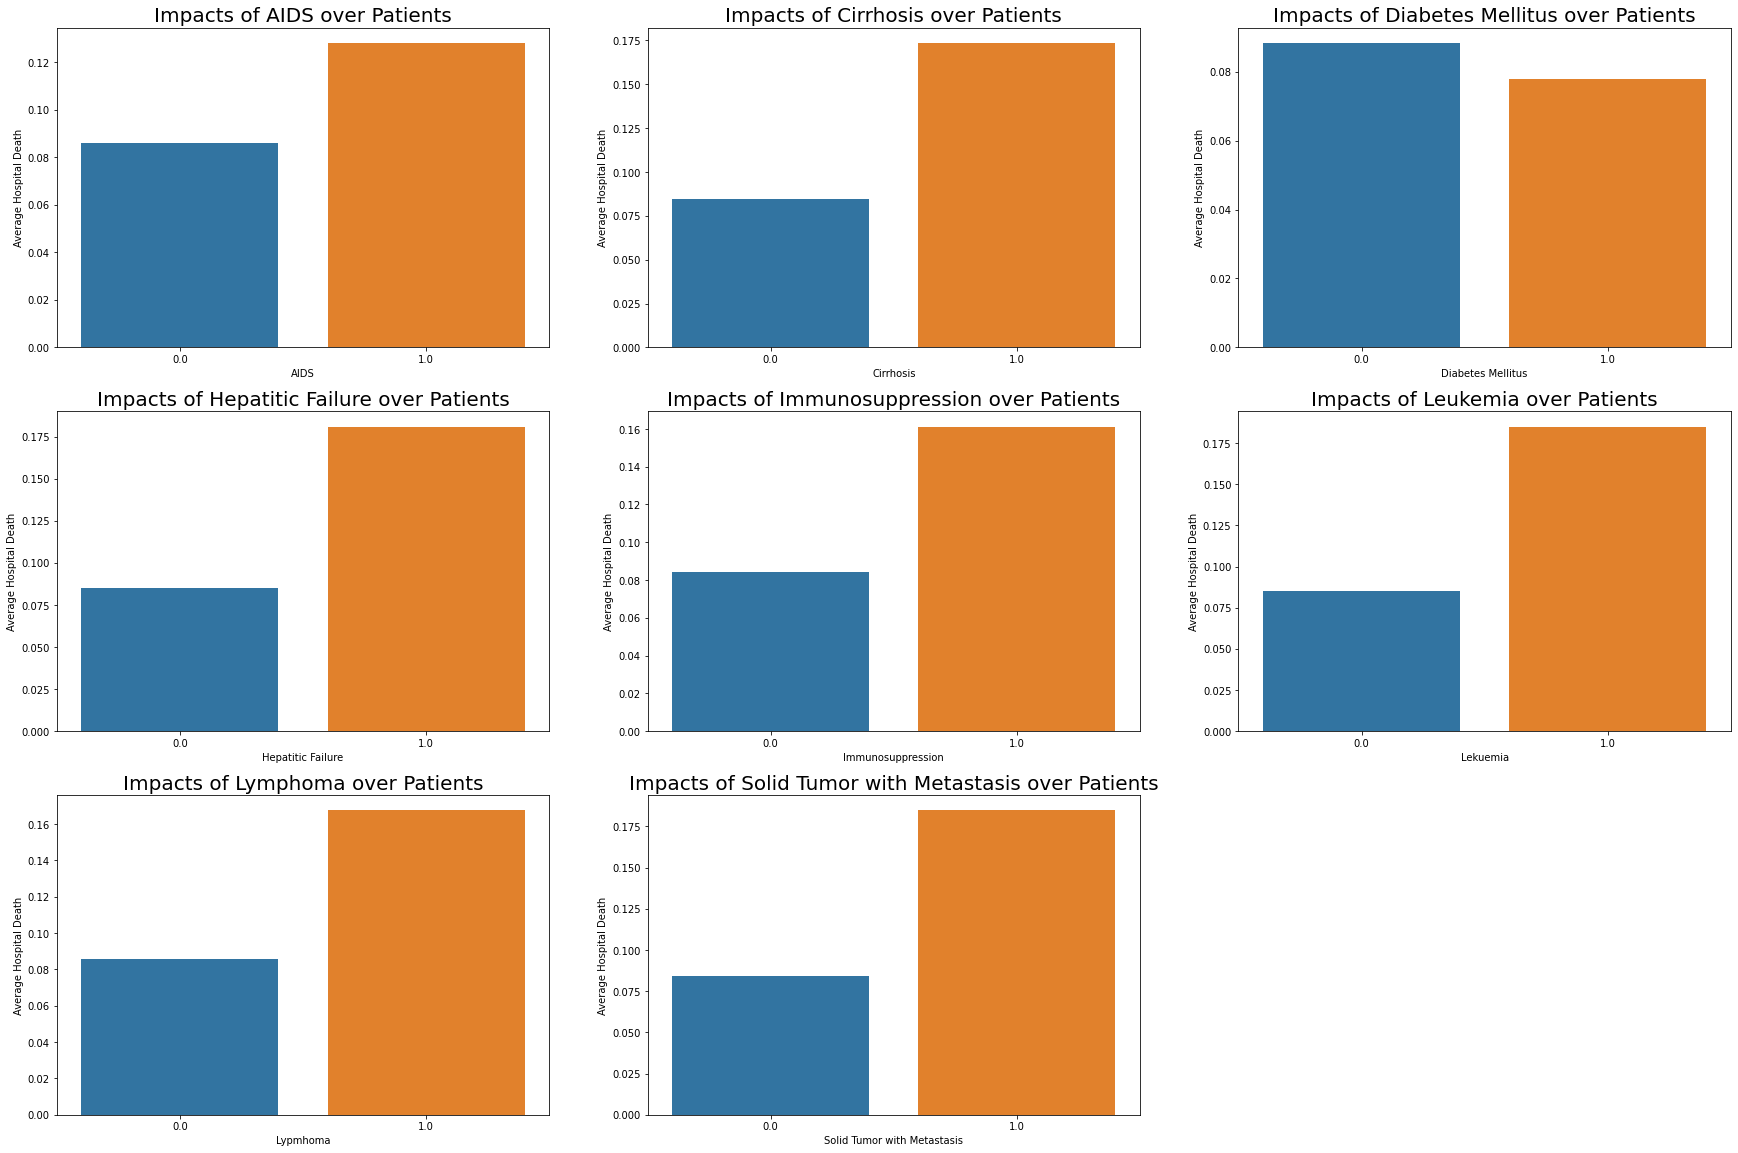

In [20]:
critical = ['hospital_death','aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
df=dataset[critical]

aids_death=df[['aids','hospital_death']].groupby('aids').mean().reset_index()
cirrhosis_death=df[['cirrhosis','hospital_death']].groupby('cirrhosis').mean().reset_index()
diabetes_mellitus_death=df[['diabetes_mellitus','hospital_death']].groupby('diabetes_mellitus').mean().reset_index()
hepatic_failure_death=df[['hepatic_failure','hospital_death']].groupby('hepatic_failure').mean().reset_index()
immunosuppression_death=df[['immunosuppression','hospital_death']].groupby('immunosuppression').mean().reset_index()
leukemia_death=df[['leukemia','hospital_death']].groupby('leukemia').mean().reset_index()
lymphoma_death=df[['lymphoma','hospital_death']].groupby('lymphoma').mean().reset_index()
solid_tumor_death=df[['solid_tumor_with_metastasis','hospital_death']].groupby('solid_tumor_with_metastasis').mean().reset_index()

fig = plt.figure(figsize=(30,20))

fig.add_subplot(3,3,1)
sns.barplot(x=aids_death['aids'], y=aids_death['hospital_death'])
plt.title("Impacts of AIDS over Patients", fontsize = 20)
plt.xlabel("AIDS")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,2)
sns.barplot(x=cirrhosis_death['cirrhosis'], y=cirrhosis_death['hospital_death'])
plt.title("Impacts of Cirrhosis over Patients", fontsize = 20)
plt.xlabel("Cirrhosis")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,3)
sns.barplot(x=diabetes_mellitus_death['diabetes_mellitus'], y=diabetes_mellitus_death['hospital_death'])
plt.title("Impacts of Diabetes Mellitus over Patients", fontsize = 20)
plt.xlabel("Diabetes Mellitus")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,4)
sns.barplot(x=hepatic_failure_death['hepatic_failure'], y=hepatic_failure_death['hospital_death'])
plt.title("Impacts of Hepatitic Failure over Patients", fontsize = 20)
plt.xlabel("Hepatitic Failure")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,5)
sns.barplot(x=immunosuppression_death['immunosuppression'], y=immunosuppression_death['hospital_death'])
plt.title("Impacts of Immunosuppression over Patients", fontsize = 20)
plt.xlabel("Immunosuppression")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,6)
sns.barplot(x=leukemia_death['leukemia'], y=leukemia_death['hospital_death'])
plt.title("Impacts of Leukemia over Patients", fontsize = 20)
plt.xlabel("Lekuemia")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,7)
sns.barplot(x=lymphoma_death['lymphoma'], y=lymphoma_death['hospital_death'])
plt.title("Impacts of Lymphoma over Patients", fontsize = 20)
plt.xlabel("Lypmhoma")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,8)
sns.barplot(x=solid_tumor_death['solid_tumor_with_metastasis'], y=solid_tumor_death['hospital_death'])
plt.title("Impacts of Solid Tumor with Metastasis over Patients", fontsize = 20)
plt.xlabel("Solid Tumor with Metastasis")
plt.ylabel("Average Hospital Death")

fig.show()

Vediamo come tutte queste variabili risultano importanti, in quanto incrementano la probabilità di decesso. L'unica eccezione è il diabete, che risulta non impattare nella probabilità di decesso (bassa in entrambi i casi)

In [21]:
important_features.extend(['aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis'])

### Altre condizioni di ricovero

Verifichiamo altre condizioni sul paziente, in particolare se questo è intubato, presenta iperventilazione, oppure si è operato da poco

C:\Users\danil\AppData\Local\Temp\ipykernel_10740\592566514.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


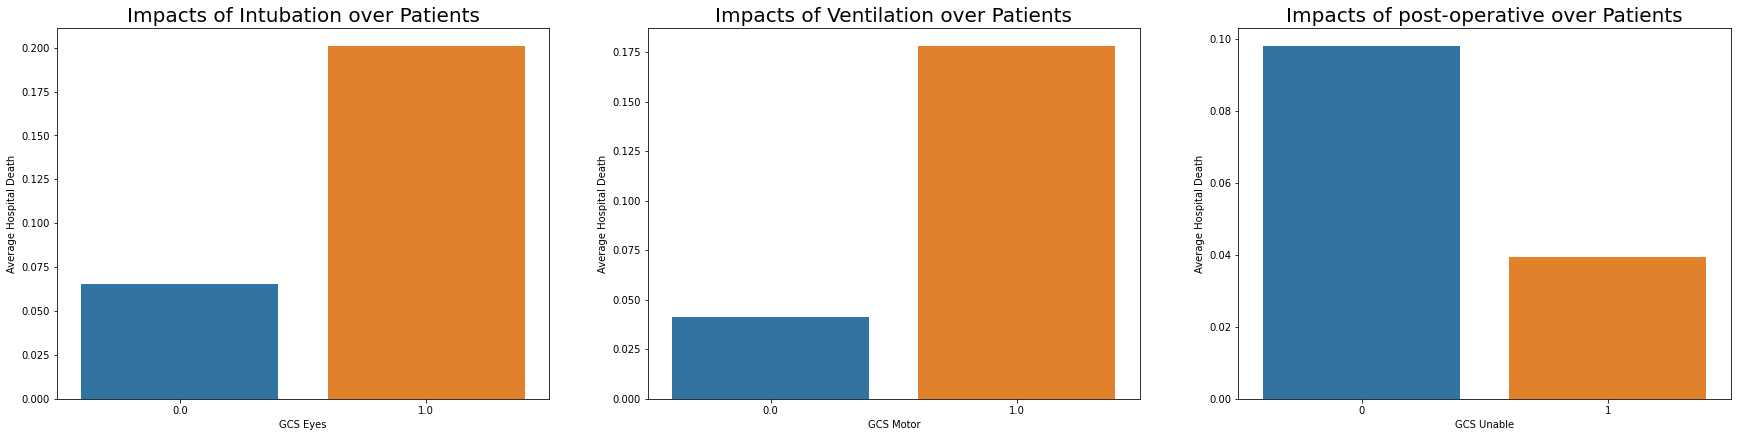

In [22]:
critical = ['hospital_death','intubated_apache', 'ventilated_apache', 'apache_post_operative']
df=dataset[critical]

intubated_apache_death=df[['intubated_apache','hospital_death']].groupby('intubated_apache').mean().reset_index()
ventilated_apache_death=df[['ventilated_apache','hospital_death']].groupby('ventilated_apache').mean().reset_index()
apache_post_operative_death=df[['apache_post_operative','hospital_death']].groupby('apache_post_operative').mean().reset_index()



fig = plt.figure(figsize=(30,15))

fig.add_subplot(2,3,1)
sns.barplot(x=intubated_apache_death['intubated_apache'], y=intubated_apache_death['hospital_death'])
plt.title("Impacts of Intubation over Patients", fontsize = 20)
plt.xlabel("GCS Eyes")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,2)
sns.barplot(x=ventilated_apache_death['ventilated_apache'], y=ventilated_apache_death['hospital_death'])
plt.title("Impacts of Ventilation over Patients", fontsize = 20)
plt.xlabel("GCS Motor")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,3)
sns.barplot(x=apache_post_operative_death['apache_post_operative'], y=apache_post_operative_death['hospital_death'])
plt.title("Impacts of post-operative over Patients", fontsize = 20)
plt.xlabel("GCS Unable")
plt.ylabel("Average Hospital Death")

fig.show()

warnings.filterwarnings('always')

Si osserva come `intubated_apache` e `ventilated_apache` aumentano significativamente la probabilità di decesso, e sono dunque da considerarsi features importanti. Al contrario riguardo `apache_post_operative` un paziente operato sembra avere una probabilità di decesso leggermente inferiore, per cui non viene considerata tra le feature importanti.  

In [23]:
important_features.extend(['intubated_apache','ventilated_apache'])

### Hospital Quality

Vediamo se diverse strutture ospedaliere hanno maggiore o minore impatto sulla mortalità dei pazienti

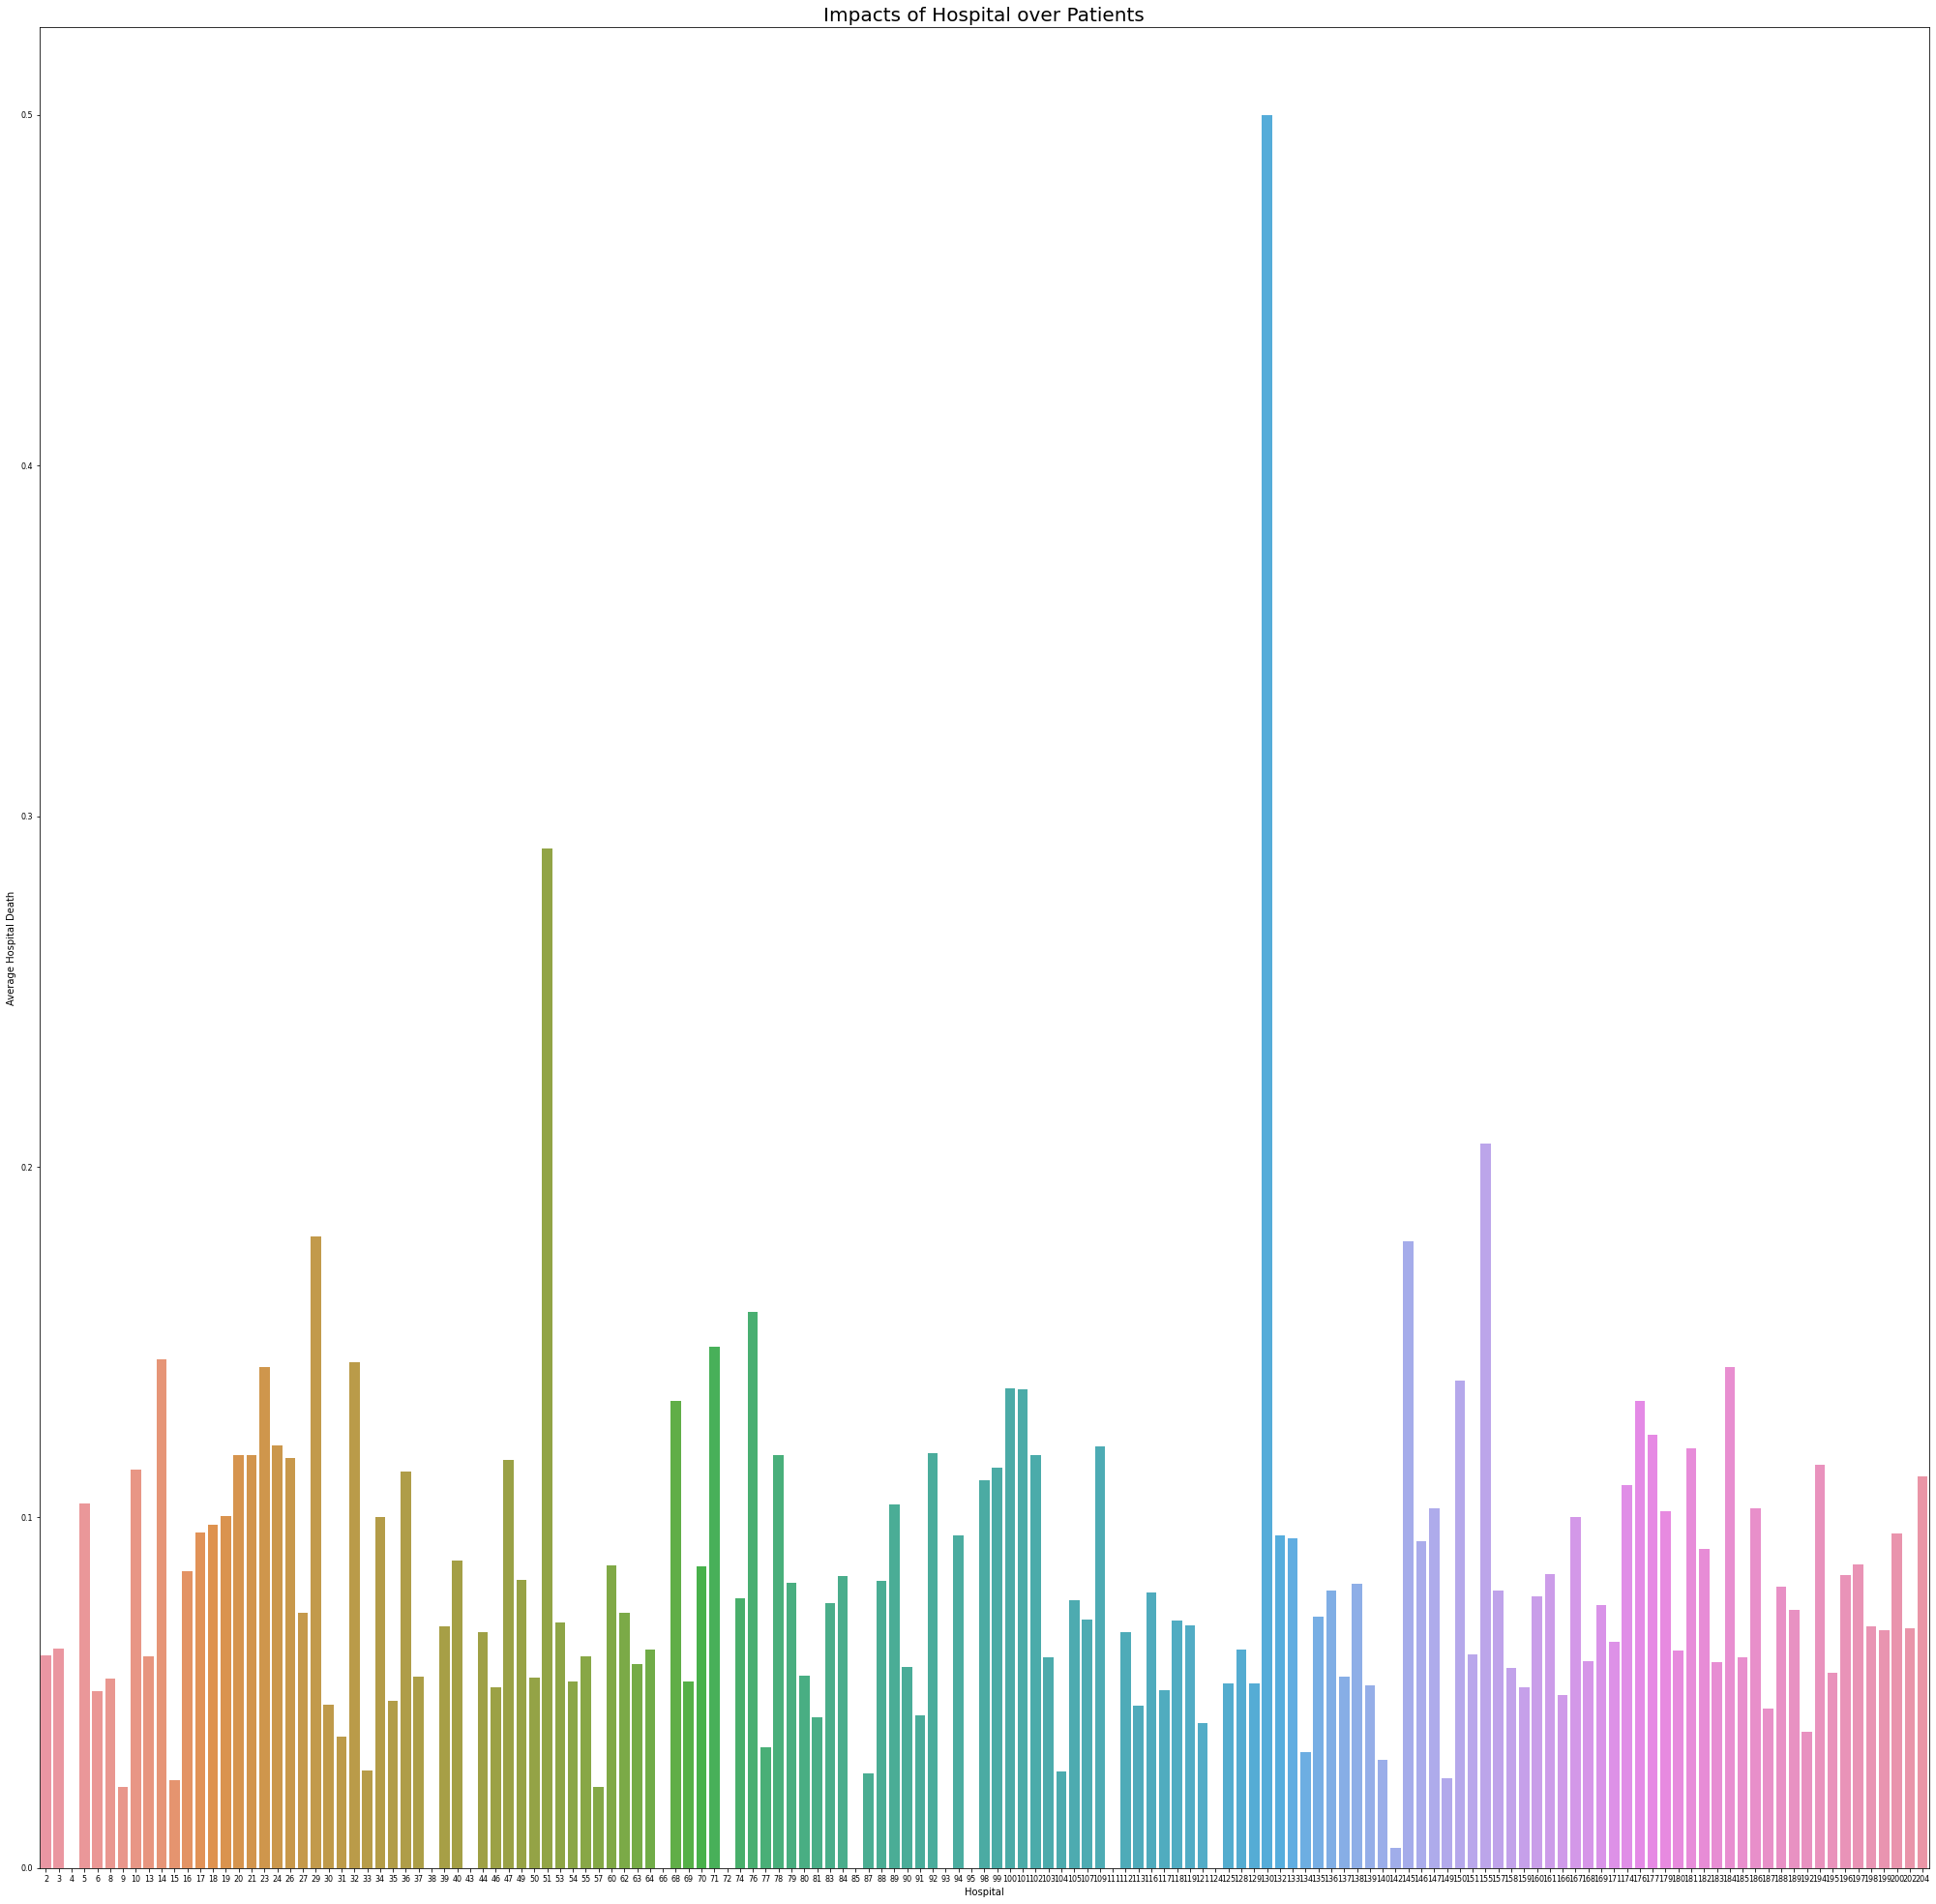

In [24]:
fig2 = plt.figure(figsize=(35,35))
hospital_death=dataset[['hospital_id','hospital_death']].groupby('hospital_id').mean().reset_index()
sns.barplot(x=hospital_death['hospital_id'], y=hospital_death['hospital_death'])
plt.title("Impacts of Hospital over Patients", fontsize = 20)
plt.xlabel("Hospital")
plt.ylabel("Average Hospital Death")
plt.tick_params(labelsize = 8)

plt.show()

Osserviamo che alcuni ospedali sembrano avere probabilità di decesso elevate. Ad esempio l'ospedale ```131``` ha il $50\%$ di decessi. Analizzando però il dataset possiamo vedere come in realtà ci siano soltanto due istanze relative all'ospedale 130, che è quindi un outlier.

In [25]:
dataset['hospital_id'].value_counts()[130]

2

Anche l'ospedale ```51``` ha una probabilità più alta di decesso. Ma anche in questo caso possiamo vedere come siano pochi i dati (110) rispetto agli altri ospedali

In [26]:
dataset['hospital_id'].value_counts()[51]

110

Anche la feature `hospital` non è quindi da considerarsi importante ai fini della classificazione, e verrà ulteriormente analizzata nella fase di *feature Engineering*.

### Features Individuate

In definitiva sono ritenute di particolare interesse nella classificazione le seguenti features

In [27]:
important_features

['age',
 'bmi',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'aids',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'intubated_apache',
 'ventilated_apache']

# Criterio di Performance Evaluation

Prima di procedere con l'ingegneria delle features è necessario definire un criterio per valutare la "bontà" di una modifica effettuata. A tale scopo, si misurano le prestazioni di tre classificatori differenti sul training set originale, e si confrontano con gli score a seguito della *Feature Engineering*. In questo modo alcuni tra i possibili approcci di *dimensionality reduction* non sono stati poi applicati, in quanto non portavano effettive migliorie sul modello (*par. "Altri tentativi di miglioramento"*.

## Training & Test Set Splitting

Andiamo a splittare il dataset in training e stesting set. Utilizziamo come percentuali $80/20$ sul dataset originale

In [28]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet:",trainX.shape)
print("TestingSet:",testX.shape)

trainX_og = trainX.copy()
testX_og = testX.copy()

TrainingSet: (73370, 84)
TestingSet: (18343, 84)


## Scelta della Metrica

Come spiegato nella Descrizione del Dataset, si è maggiormente interessati ad **evitare i falsi negativi**, ovvero istanze predete come `survived` ma che sono in realtà `death`. Di conseguenza, la principale metrica considerata per valutare le prestazioni dei vari modelli è la <b>recall</b>: $$Recall = \frac{TP}{TP + FN}$$

Tuttavia, si deve tener conto anche dei **FP**, valutando un tradeoff tra i due indici per evitare un aumento eccessivo degli errori di classificazione sui pazienti `survived`.

## Risultati sul Dataset Originale

Andiamo a misurare le prestazioni di vari classificatori sul dataset originale, quindi senza ingegneria delle features e imputazione dei valori mancanti. 
- *Logistic Regression*, *Decision Tree*, *Gaussian Naive Bayes*
- I classificatori considerati non gestiscono in modo automatico i valori ```NaN```
- Per eseguire la classificazione è comunque necessario mappare i valori ```NaN``` su un qualche valore numerico
- Si utilizza per questa fase di benchmark l'operatore ```fillna(-1)``` sostituendo quindi ```NaN``` con ```-1```

In [29]:
run_classifications(trainX,trainY,testX,testY, fill = True, experiment="Original Dataset")
scores = pd.DataFrame(scores_dict).T
original_scores = scores.copy()
original_scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.647577  0.916208     0.175943  0.824057   
Decision Tree Classifier         0.338895  0.878373     0.352484  0.647516   
Gaussian Naive Bayes Classifier  0.285174  0.840811      0.49611   0.50389   

                                      TNR       FPR        experiment  
Logistic Regression Classifier   0.990403  0.009597  Original Dataset  
Decision Tree Classifier         0.931082  0.068918  Original Dataset  
Gaussian Naive Bayes Classifier   0.87536   0.12464  Original Dataset

# Feature Engineering

Andiamo ad eseguire diverse operazioni per ridurre la dimensionalità del dataset, rimuovendo quelle features non rilevanti ai fini della classificazione.
- Rimozione feature con valori nulli
- Rimozione feature con bassa varianza dei dati
- Rimozione feature con bassa correlazione con il target 
- Feature Selection
- Altri tentativi di miglioramento

## Rimozione features con valori nulli

Rimuoviamo quelle colonne il cui valore percentuale di colonne nulle supera l'80%, e su cui risulterebbe inutile l'imputazione dei dati mancanti.

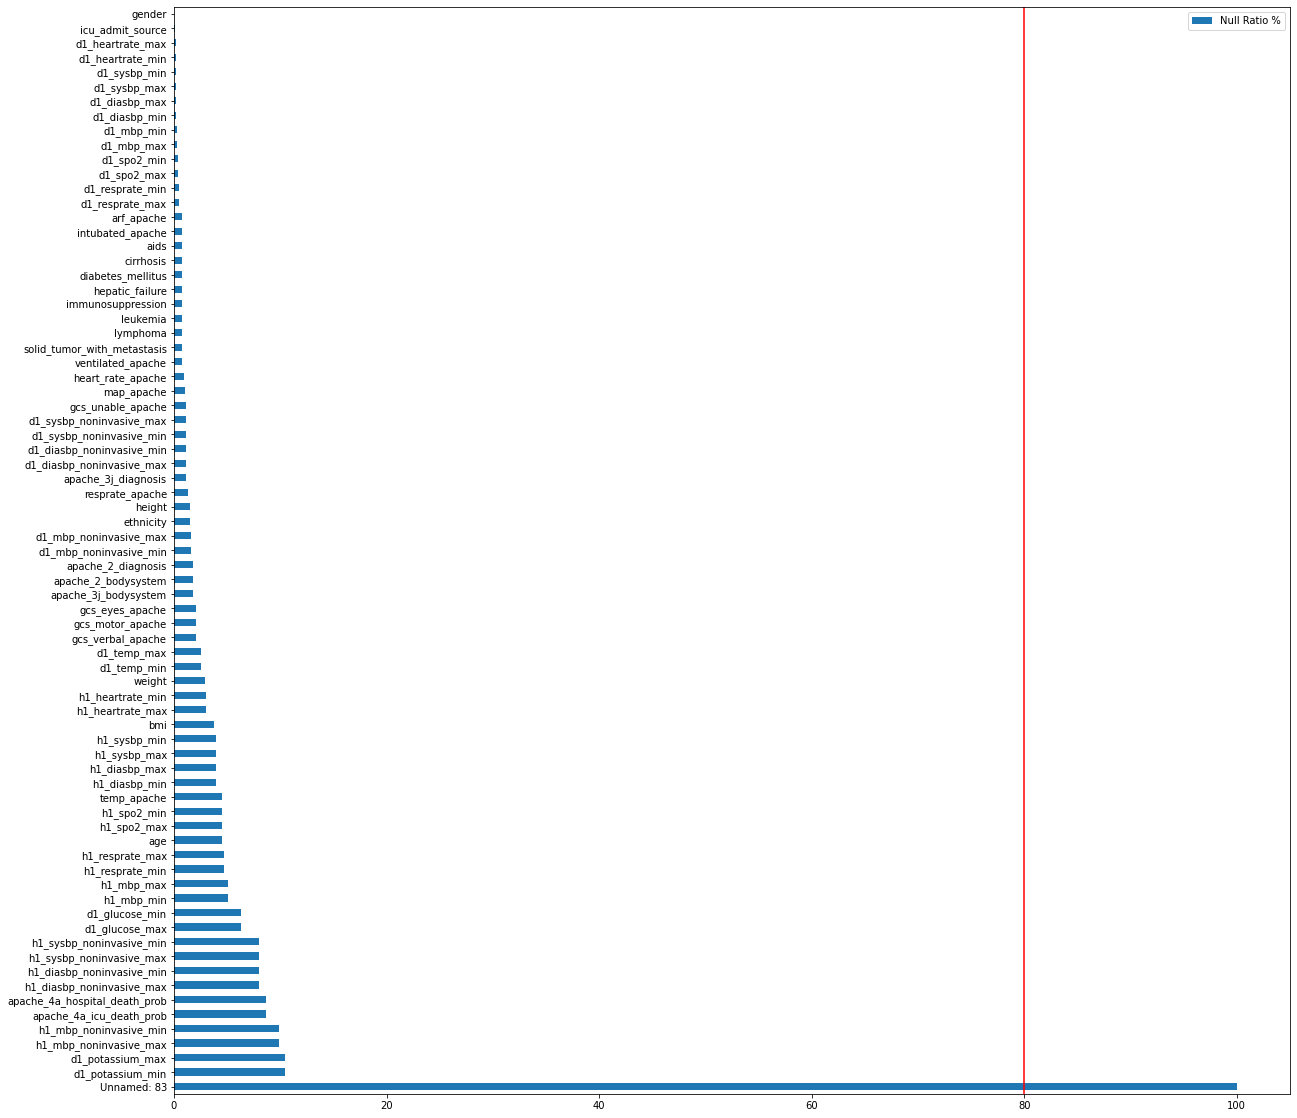

['Unnamed: 83']


In [30]:
features_to_remove = plot_nas(trainX,use_threshold=True,threshold=80)

Soltanto la feature `Unnamed: 83` supera la soglia prefissata, per cui la rimuoviamo dal dataset

In [31]:
drop_features_from_trainset(features_to_remove)

Training Set Updated: (73370, 84) -> (73370, 83)


## Rimozione features con bassa varianza

Otteniamo la lista delle feature che presentano una varianza minore ad 0.01

In [32]:
original_cols = trainX_og.columns
threshold = 0.01

selector = VarianceThreshold(threshold)
selector.fit(trainX)
features_to_remove = [x for x in trainX.columns if x not in selector.get_feature_names_out()]
print("Features to remove:",features_to_remove)

Features to remove: ['gcs_unable_apache', 'aids', 'leukemia', 'lymphoma']


Anche se poco variabili, `gcs_unable_apache`, `aids`, `apache_2_bodysystem` e `lymphoma`, come visto nell'analisi delle feature, sono tutte importanti ai fini della classificazione e non andiamo quindi a rimuoverle.
- Tutte le features individuate tramite `VarianceThreshold` sono in realtà ritenute importanti dall'analisi del dominio.

In [33]:
features_to_remove = list(set(features_to_remove) - set(important_features))
drop_features_from_trainset(features_to_remove)

No features dropped!


## Rimozione features con bassa correlazione col target

Ricaviamo le features che hanno una bassa correlazione con il target, inferiore ad una threshold di $0.03$

In [34]:
features_to_remove = get_low_correlated_features(0.03)
print(features_to_remove)

['encounter_id', 'patient_id', 'hospital_id', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'arf_apache', 'd1_diasbp_max', 'd1_diasbp_noninvasive_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_noninvasive_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_sysbp_max', 'd1_sysbp_noninvasive_max', 'd1_temp_max', 'd1_glucose_min', 'd1_potassium_min', 'aids', 'diabetes_mellitus', 'leukemia', 'lymphoma']


Anche in questo caso non rimuoviamo le feature `gcs_unable_apache`, `aids`, `apache_2_bodysystem` e `lymphoma`.

In [35]:
to_delete = list(set(features_to_remove) - set(important_features))
print(to_delete)

['icu_type', 'd1_glucose_min', 'arf_apache', 'patient_id', 'icu_admit_source', 'ethnicity', 'd1_diasbp_max', 'hospital_id', 'd1_sysbp_noninvasive_max', 'd1_mbp_max', 'd1_potassium_min', 'd1_resprate_min', 'icu_id', 'diabetes_mellitus', 'd1_sysbp_max', 'encounter_id', 'd1_temp_max', 'icu_stay_type', 'd1_heartrate_min', 'd1_diasbp_noninvasive_max', 'd1_mbp_noninvasive_max', 'height', 'd1_spo2_max', 'gender']


Rimuoviamo le feature individuate dal dataset

In [36]:
drop_features_from_trainset(to_delete)

Training Set Updated: (73370, 83) -> (73370, 59)


## Feature Selection

Si utilizza la **Backward Stepwise Feature Selection** come ulteriore tecnica per la riduzione della dimensionalità. Questa viene eseguita a partire dal sottoinsieme di feature individuate dopo aver applicato le tecniche precedentemente descritte.

In [38]:
selected,removed = backward_feature_selection()

Rimuoviamo dal training set le feature non selezionate

In [40]:
features_to_remove = list(set(removed) - set(important_features))
drop_features_from_trainset(features_to_remove)

Training Set Updated: (73370, 59) -> (73370, 44)


Vediamo che al termine della fase di pulizia abbiamo ridotto notevolmente la dimensionalità del dataset, passando da $84$ a $44$ features

## Confronto Prestazioni

Confrontiamo le prestazioni ottenute nel training set originale con quelle a seguito della *dimensionality reduction*.

In [41]:
original_scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.647577  0.916208     0.175943  0.824057   
Decision Tree Classifier         0.338895  0.878373     0.352484  0.647516   
Gaussian Naive Bayes Classifier  0.285174  0.840811      0.49611   0.50389   

                                      TNR       FPR        experiment  
Logistic Regression Classifier   0.990403  0.009597  Original Dataset  
Decision Tree Classifier         0.931082  0.068918  Original Dataset  
Gaussian Naive Bayes Classifier   0.87536   0.12464  Original Dataset

In [42]:
run_classifications(trainX,trainY,testX,testY, fill = True, experiment="Feature Engineering")
scores = pd.DataFrame(scores_dict).T
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.657944  0.918116     0.210652  0.789348   
Decision Tree Classifier         0.331606   0.87701     0.344704  0.655296   
Gaussian Naive Bayes Classifier  0.298043  0.840266     0.555955  0.444045   

                                      TNR       FPR           experiment  
Logistic Regression Classifier   0.989024  0.010976  Feature Engineering  
Decision Tree Classifier         0.930362  0.069638  Feature Engineering  
Gaussian Naive Bayes Classifier  0.868762  0.131238  Feature Engineering

## Imputazione dei dati mancanti

Si utilizza un meccanismo di **imputazione** per sopperire alla presenza di dati mancanti delle diverse features del dataset. L'obiettivo è quello di ripristinare le diverse variabili per l'uso nella classificazione rimpiazzando tutti i dati nulli con valori derivati da entry simili nel dataset. A tale scopo si utilizza il **k-Nearest Neighbors Imputer**, che sfrutta l'algoritmo *k-Nearest* per individuare il nodo più vicino da cui prelevare il dato mancante.

In [43]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
trainX_imp = pd.DataFrame(imp.fit_transform(trainX), columns = trainX.columns)

Confrontiano i risultati ottenuti con e senza *data imputation*

In [44]:
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.657944  0.918116     0.210652  0.789348   
Decision Tree Classifier         0.331606   0.87701     0.344704  0.655296   
Gaussian Naive Bayes Classifier  0.298043  0.840266     0.555955  0.444045   

                                      TNR       FPR           experiment  
Logistic Regression Classifier   0.989024  0.010976  Feature Engineering  
Decision Tree Classifier         0.930362  0.069638  Feature Engineering  
Gaussian Naive Bayes Classifier  0.868762  0.131238  Feature Engineering

In [46]:
run_classifications(trainX_imp,trainY,testX,testY, fill = False, experiment="Imputation")
scores = pd.DataFrame(scores_dict).T
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.288104  0.859183     0.371035  0.628965   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   

                                      TNR       FPR  experiment  
Logistic Regression Classifier   0.978527  0.021473  Imputation  
Decision Tree Classifier         0.908109  0.091891  Imputation  
Gaussian Naive Bayes Classifier  0.768714  0.231286  Imputation

Osserviamo che tutti gli score di recall migliorano ulteriormente, pertanto procediamo ad utilizzare il training set ricavato.
- Si mantengono i `NaN` nel testing set mappandoli a `-1`
- *NOTA*: L'imputazione dei dati è stata effettuata a valle della Feature Selection in modo da ridurre il costo necessario all'esecuzione del `KNNIMputer`

In [50]:
trainX = trainX_imp.copy()
testX = testX.fillna(-1)

## Altri tentativi di Miglioramento

Analizziamo ulteriori tecniche applicate per migliorare la qualità del dataset.

### PCA: Principal Component Analysis

Cerchiamo di ridurre ulteriormente la dimensionalità del dataset applicando la Principal Component Analysis.

In [51]:
print(trainX.shape)
pca = PCA(n_components=int(trainX.shape[1]*0.7))
trainX_pca = pd.DataFrame(pca.fit_transform(trainX))
testX_pca = pd.DataFrame(pca.transform(testX))
print(trainX_pca.shape)

(73370, 44)
(73370, 30)


Analizziamo i risultati a seguito di PCA

In [52]:
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.288104  0.859183     0.371035  0.628965   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   

                                      TNR       FPR  experiment  
Logistic Regression Classifier   0.978527  0.021473  Imputation  
Decision Tree Classifier         0.908109  0.091891  Imputation  
Gaussian Naive Bayes Classifier  0.768714  0.231286  Imputation

In [53]:
run_classifications(trainX_pca,trainY,testX_pca,testY, experiment="PCA after FE")
scores_pca = pd.DataFrame(scores_dict).T
scores_pca

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.329859  0.883988     0.265111  0.734889   
Decision Tree Classifier         0.209098  0.825928     0.327349  0.672651   
Gaussian Naive Bayes Classifier  0.163746  0.695524     0.570317  0.429683   

                                      TNR       FPR    experiment  
Logistic Regression Classifier   0.946017  0.053983  PCA after FE  
Decision Tree Classifier           0.8759    0.1241  PCA after FE  
Gaussian Naive Bayes Classifier  0.708073  0.291927  PCA after FE

I risultati risultano inferiori a seguito dell'applicazione di PCA sull'ultimo insieme di features individuate. Proviamo anche ad applicare PCA sull'insieme originale di features, per verificare se questo operi meglio rispetto al processo di selezione applicato. Anche in questo caso vengono generate 30 features sintetiche. Possiamo però osservare come i risultati siano addirittura peggiori rispetto al caso precedente

In [54]:
print(trainX_og.shape)
pca = PCA(n_components=int(trainX.shape[1]*0.7))
trainX_pca = pd.DataFrame(pca.fit_transform(trainX_og.fillna(-1)))
testX_pca = pd.DataFrame(pca.transform(testX_og.fillna(-1)))
print(trainX_pca.shape)

run_classifications(trainX_pca,trainY,testX_pca,testY,experiment="PCA without FE")
scores_pca = pd.DataFrame(scores_dict).T
scores_pca

(73370, 84)
(73370, 30)


Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.617225  0.911574     0.077199  0.922801   
Decision Tree Classifier         0.237201  0.858529     0.249551  0.750449   
Gaussian Naive Bayes Classifier  0.229354  0.843155     0.305805  0.694195   

                                      TNR       FPR      experiment  
Logistic Regression Classifier   0.995202  0.004798  PCA without FE  
Decision Tree Classifier         0.919566  0.080434  PCA without FE  
Gaussian Naive Bayes Classifier  0.897013  0.102987  PCA without FE

In definitiva non viene applicata PCA in quanto si hanno risultati migliori applicando soltanto l'ingegneria delle features descritta in precedenza.

### Sampling

Come visto nella Data Exploration il dataset risulta fortemente sbilanciato. Anche a seguito dello splitting in training e testing set resta tale sbilanciamento.

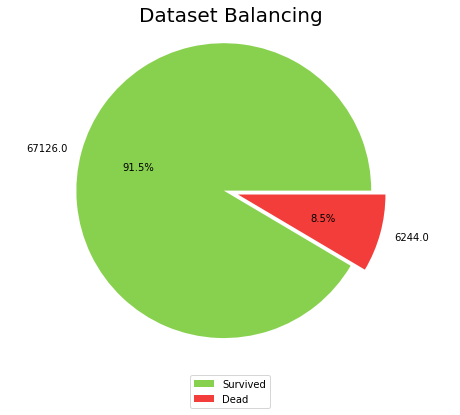

In [55]:
classes = [{"Survived": (trainY== 0).sum(), "Dead": (trainY== 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'], explode=[0.05,0.05])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Questo, come già visto nell'analisi preliminare porta il modello a classificare più frequentemente le classi come `survived`, in quanto ha molti più dati in percentuale su cui effettuare il training. Per questo si possono applicare diverse strategie per cercare di ripristinare il bilanciamento del dataset:

- Undersampling
- Oversampling
- SMOTE

![](.img/sampling.jpg)

#### Undersampling

In [56]:
num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Removing",num_under,"istances")

rus = RandomUnderSampler(random_state=0)
trainX_und,trainY_und = rus.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

Removing 60882 istances


Vediamo dai risultati che peggiorano tutte le metriche applicando il balancing.

In [57]:
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.288104  0.859183     0.371035  0.628965   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   

                                      TNR       FPR  experiment  
Logistic Regression Classifier   0.978527  0.021473  Imputation  
Decision Tree Classifier         0.908109  0.091891  Imputation  
Gaussian Naive Bayes Classifier  0.768714  0.231286  Imputation

In [58]:
run_classifications(trainX_und,trainY_und,testX_og,testY,experiment="undersampling")
scores_und = pd.DataFrame(scores_dict).T
scores_und

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.272999  0.792946      0.76541   0.23459   
Decision Tree Classifier         0.197676  0.713133     0.702573  0.297427   
Gaussian Naive Bayes Classifier  0.243139  0.792564     0.604428  0.395572   

                                      TNR       FPR     experiment  
Logistic Regression Classifier   0.795705  0.204295  undersampling  
Decision Tree Classifier         0.714191  0.285809  undersampling  
Gaussian Naive Bayes Classifier   0.81142   0.18858  undersampling

Come atteso migliorano effettivamente le classificazioni di classi `death` rispetto a `survived`. Tuttavia rimuovendo $60882$ istanze dal training set si ha una significativa perdita di informazioni, che porta l'**accuracy** del modello a decrescere significativamente. Inoltre possiamo vedere all'aumento della `recall` corrisponda un abbassamento della `precision`, indice del fatto che il classificatore tende semplicemente a classificare più istanze come positive (aumentano i falsi negativi).

#### Oversampling

In [59]:
num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Creating",num_under,"istances")

ros = RandomOverSampler(random_state=0)
trainX_ov,trainY_ov = ros.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

Creating 60882 istances


In [60]:
run_classifications(trainX_ov,trainY_ov,testX_og,testY,experiment="oversampling")

In [61]:
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.288104  0.859183     0.371035  0.628965   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   

                                      TNR       FPR  experiment  
Logistic Regression Classifier   0.978527  0.021473  Imputation  
Decision Tree Classifier         0.908109  0.091891  Imputation  
Gaussian Naive Bayes Classifier  0.768714  0.231286  Imputation

In [62]:
scores_ov = pd.DataFrame(scores_dict).T
scores_ov

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.271056  0.792128     0.758827  0.241173   
Decision Tree Classifier         0.337136  0.880881     0.318372  0.681628   
Gaussian Naive Bayes Classifier  0.247053  0.794254     0.614602  0.385398   

                                      TNR       FPR    experiment  
Logistic Regression Classifier   0.795465  0.204535  oversampling  
Decision Tree Classifier          0.93726   0.06274  oversampling  
Gaussian Naive Bayes Classifier   0.81226   0.18774  oversampling

#### SMOTE (Synthetic Minority Oversampling Technique)

In [63]:
smote = SMOTE(random_state=0)
trainX_smote, trainY_smote = smote.fit_resample(trainX.fillna(-1), trainY)

run_classifications(trainX_smote,trainY_smote,testX,testY,fill=True,experiment="SMOTE")

In [64]:
scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.288104  0.859183     0.371035  0.628965   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   

                                      TNR       FPR  experiment  
Logistic Regression Classifier   0.978527  0.021473  Imputation  
Decision Tree Classifier         0.908109  0.091891  Imputation  
Gaussian Naive Bayes Classifier  0.768714  0.231286  Imputation

In [65]:
scores_smote = pd.DataFrame(scores_dict).T
scores_smote

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.253903  0.778281     0.739677  0.260323   
Decision Tree Classifier         0.274167   0.84828      0.40395   0.59605   
Gaussian Naive Bayes Classifier  0.227247  0.753694     0.709755  0.290245   

                                      TNR       FPR experiment  
Logistic Regression Classifier    0.78215   0.21785      SMOTE  
Decision Tree Classifier         0.892814  0.107186      SMOTE  
Gaussian Naive Bayes Classifier  0.758097  0.241903      SMOTE

Come possiamo osservare, applicando il sampling si nota effettivamente un miglioramento generale nella classificazione delle classi `death`. Tra tutti i metodi applicati, **SMOTE** è quello che fornisce risultati migliori in termini di `recall`, andando a creare istanze artificiali comunque simili a quelle già presenti (al contrario dell'oversampling di tipo randomico).

Teniamo in considerazione l'utilizzo di tale tecnica sul training set in un confronto finale delle prestazioni.

# Model Selection

Andiamo ad effettuare la fase di **model selection**, per stabilire i migliori iperparametri su ognuno dei modelli considerati ai fini della classificazione. 

Questa viene effettuata in generale sfruttando la ricerca esaustiva tramite `GridSearchCV`. Il miglior estimatore viene individuato considerando la metrica di ```recall``` su un'esecuzione **5Fold-Cross-Validation**.

## Logistic Regression

Si considera l'ottimizzazione dei seguenti iperparametri:
- `penalty` = `{l1,l2}`, regolarizzazione *lasso* o *ridge*
- `C`, *regularization strenght*, ovvero il coefficiente di regolarizzazion *(minore il valore, maggiore il peso della regolarizzazione)*

In [73]:
params = {'penalty':['l1','l2'], 'C':[0.1, 1]}
lrc = LogisticRegression(solver="liblinear")
gscv_lr = GridSearchCV(lrc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)
gscv_lr.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'penalty': ['l1', 'l2']},
             scoring='recall')

Vengono selezionati i seguenti iperparametri:
- `penalty = l1`
- `C = 1`

In [74]:
print("Best Estimator: ",gscv_lr.best_estimator_)

Best Estimator:  LogisticRegression(C=1, penalty='l1', solver='liblinear')


Questo ci dice che non viene di fatto applicata la regolarizzazione, che peggiora i risultati rispetto al considerare l'intero dominio del training set. Questo vuol dire che il modello considerato non soffre in realtà di problemi di Overfitting, e quindi andandone a limitare il dominio si rimuovono informazioni utili al classificatore.

## Decision Tree Classifier

I risultati ottenuti dalla model selection vedono ottenere una `recall` maggiore utilizzando come funzione di misurazione della qualità di ogni splitting la funzione `gini`.

In [75]:
params = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'min_samples_split':[2, 3, 5], 'max_depth':[None, 10]}
dtc = DecisionTreeClassifier()
gscv_dtc = GridSearchCV(dtc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_dtc.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10],
                         'min_samples_split': [2, 3, 5],
                         'splitter': ['best', 'random']},
             scoring='recall')

Vediamo che vengono trovati i seguenti iperparametri:
- `criterion = gini`
- `splitter = best`
- `min_samples_split = 2`
- `max_depth = None`


In [76]:
print("Best Estimator: ",gscv_dtc.best_estimator_)
print("Best Params: ", gscv_dtc.best_params_)

Best Estimator:  DecisionTreeClassifier()
Best Params:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'best'}


## Naive Bayes Classifier

Un classificatore bayesiano richiede la *conoscenza delle probabilità a priori*.  Tra i classificatori naive bayes occorre scegliere la **distribuzione a priori** da considerare, e come abbiamo visto dall'analisi delle features, la maggior parte di esse presentano una *distribuzione simile ad una Gaussiana*.

Verifichiamo quindi i risultati ottenuti assumendo una distribuzione a priori Gaussiana, e confrontiamoli con il caso di un prior di tipo Bernoulliano.

In [77]:
scores_dict = {}
gnb = GaussianNB()
run_classifications(trainX,trainY,testX,testY, fill = True, model=gnb, model_name="Naive Bayes Classifier (1)", experiment = "Gaussian Prior")

bbn = BernoulliNB()
run_classifications(trainX,trainY,testX,testY, fill = True, model=bbn, model_name="Naive Bayes Classifier (2)", experiment = "Bernoullian Prior")

scores_nb = pd.DataFrame(scores_dict).T
scores_nb

Precision  Accuracy TPR (recall)       FNR  \
Naive Bayes Classifier (1)  0.218484  0.757455     0.645123  0.354877   
Naive Bayes Classifier (2)   0.17372  0.732377     0.515859  0.484141   

                                 TNR       FPR         experiment  
Naive Bayes Classifier (1)  0.768714  0.231286     Gaussian Prior  
Naive Bayes Classifier (2)  0.754079  0.245921  Bernoullian Prior

Dai risultati possiamo osservare come la recall sia nettamente superiore nel caso della distribuzione gaussiana ($0.55$ vs $0.14$), a fronte di un TNR che decresce solo del $9$.

Una volta aver selezionato il modello da utilizzare (Gaussian Naive Bayes), occorre effettuare il tuning degli iperparametri, ovvero media e varianza della gaussiana. Tali parametri vengono automaticamente selezionati dal modello *sklearn*, scegliendo *media* e *varianza* più adatti in base ai dati a disposizione.

## Random Forest Classifier

Il **Random Forest** è un metodo bagging tra i più utilizzati in machine learning, che utilizza come weak-learner degli alberi di decisione.
- Tali alberi di decisione sono diversi tra loro perché allenati su training set differenti, ottenuti tramite Boostrap.
- Sono detti Random perché l’insieme delle feature rispetto a cui decidere se tagliare lo spazio è in realtà un sottoinsieme casuale delle feature.
- Tale randomizzazione contribuisce a rendere diversi tra loro i vari classificatori.

Dopo aver costruito $𝑇_𝐵$ alberi di decisione, la predizione finale viene effettuata per maggioranza (in caso di classificazione) o tramite la media dei risultati (in caso di regressione) su tutte le predizioni effettuate da ogni albero.

Avendo già individuato i migliori iperparametri per il singolo weak learner, si fissano i valori:
- `criterion = gini`
- `min_samples_split = 2`
- `max_depth = None`

Pertanto l'unico parametro da valutare è  `n_estimators`, ovvero il *numero di Decision Trees* da considerare nella foresta.

In [79]:
params = {'n_estimators':[10,100,500]}
rfc = RandomForestClassifier(criterion='gini',min_samples_split=2,max_depth=None)
gscv_dtc = GridSearchCV(rfc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)
gscv_dtc.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=-1, param_grid={'n_estimators': [10, 100, 500]},
             scoring='recall')

Le migliori prestazioni si hanno per `n_estimators = 500` 

In [80]:
print("Best Estimator: ",gscv_dtc.best_estimator_)
print("Best Params: ", gscv_dtc.best_params_)

Best Estimator:  RandomForestClassifier(criterion='entropy', n_estimators=500)
Best Params:  {'n_estimators': 500}


Verifichiamo le prestazioni con 500 e 100 weak learners.

In [94]:
scores_dict={}
rfc_500 = RandomForestClassifier(criterion='gini',min_samples_split=2,max_depth=None, n_estimators=500)
rfc_100 = RandomForestClassifier(criterion='gini',min_samples_split=2,max_depth=None, n_estimators=100)
run_classifications(trainX,trainY,testX,testY,model=rfc,model_name="Random Forest w/500",fill=True, experiment = "500 Learners")
run_classifications(trainX,trainY,testX,testY,model=rfc,model_name="Random Forest w/100",fill=True, experiment = "100 Learners")

scores_rf = pd.DataFrame(scores_dict).T
scores_rf


Precision  Accuracy TPR (recall)       FNR       TNR  \
Random Forest w/500       0.7  0.922423     0.259725  0.740275  0.988844   
Random Forest w/100  0.696063  0.922477     0.264512  0.735488  0.988424   

                          FPR    experiment  
Random Forest w/500  0.011156  500 Learners  
Random Forest w/100  0.011576  100 Learners

I risultati sperimentali risultano sensibilmente migliori in termine di `precision`, mentre la `recall` di interesse (calcolata sulla classe `1`) è leggermente inferiore con 500 learners. Considerando quindi anche che la complessità computazionale aumenta di dieci volte *(6 min vs 21 sec)*, si è deciso di mantenere il parametro standard di `n_estimators` pari a `100`.

## Support Vector Machine

Un iperparametro delle SVM è la **funzione kernel** che andrà ad utilizzare nell'individuazione dell'iperpiano di separazione. La principali funzioni kernel messe a disposizione dal framework sklearn sono:
- `lineare`
- `polimoniale`
- `rbf`
- `sigmoide`

Nel nostro caso, utilizzando un kernel `lineare` non viene raggiunta una convergenza e di conseguenza la SVM classificherà tutti gli elementi come `survived`.  
Utilizzando il kernel `polinomiale` otteniamo un elevato score di accuracy ($0.90$) ma un basso valore di recall pari a $0.28$; questo indica il fatto che vengono ancora classificati molti pazienti `survived` come `death`.   
Utilizzando invece il kernel `rbf` si ottiene una `recall` nettamente peggiore ($0.16$ ), a fronte di una `accuracy` leggermente migliore ($0.92$). Il risultato peggiore si ha invece sfruttando il kernel `sigmoid`, che fornisce l'`accuracy` più bassa ($0.88$) e anche una bassa `recall` ($0.18$)

In [95]:
scaler = StandardScaler()

trainX_scaled = pd.DataFrame(scaler.fit_transform(trainX.fillna(-1)),columns = trainX.columns)
testX_scaled = pd.DataFrame(scaler.transform(testX.fillna(-1)),columns = testX.columns)

In [96]:
svc_classifier = SVC(kernel='poly')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_POLY')

In [97]:
scores_poly = pd.DataFrame(scores_dict).T
scores_poly

Precision  Accuracy TPR (recall)       FNR       TNR  \
Random Forest w/500       0.7  0.922423     0.259725  0.740275  0.988844   
Random Forest w/100  0.696063  0.922477     0.264512  0.735488  0.988424   
SVC_POLY             0.396523  0.895273     0.286655  0.713345  0.956274   

                          FPR    experiment  
Random Forest w/500  0.011156  500 Learners  
Random Forest w/100  0.011576  100 Learners  
SVC_POLY             0.043726           NaN

In [98]:
svc_classifier = SVC(kernel='rbf')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_RBF')

In [99]:
scores_rbf = pd.DataFrame(scores_dict).T
scores_rbf

Precision  Accuracy TPR (recall)       FNR       TNR  \
Random Forest w/500       0.7  0.922423     0.259725  0.740275  0.988844   
Random Forest w/100  0.696063  0.922477     0.264512  0.735488  0.988424   
SVC_POLY             0.396523  0.895273     0.286655  0.713345  0.956274   
SVC_RBF              0.725806  0.918061      0.16158   0.83842  0.993882   

                          FPR    experiment  
Random Forest w/500  0.011156  500 Learners  
Random Forest w/100  0.011576  100 Learners  
SVC_POLY             0.043726           NaN  
SVC_RBF              0.006118           NaN

In [100]:
svc_classifier = SVC(kernel='sigmoid')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_SIGMOID')

In [101]:
scores_sigmoid = pd.DataFrame(scores_dict).T
scores_sigmoid

Precision  Accuracy TPR (recall)       FNR       TNR  \
Random Forest w/500       0.7  0.922423     0.259725  0.740275  0.988844   
Random Forest w/100  0.696063  0.922477     0.264512  0.735488  0.988424   
SVC_POLY             0.396523  0.895273     0.286655  0.713345  0.956274   
SVC_RBF              0.725806  0.918061      0.16158   0.83842  0.993882   
SVC_SIGMOID          0.206634  0.862618     0.178935  0.821065  0.931142   

                          FPR    experiment  
Random Forest w/500  0.011156  500 Learners  
Random Forest w/100  0.011576  100 Learners  
SVC_POLY             0.043726           NaN  
SVC_RBF              0.006118           NaN  
SVC_SIGMOID          0.068858           NaN

## AdaBoost Classifier

**Adaboost** è un algoritmo di *ensemble learning* che utilizza il metodo *Boosting*, ovvero i classificatori vengono addestrati in sequenza, ognuno dei quali costruito sulla base del comportamento del precedente.  
Come classificatore base, sul quale viene applicato il metodo di boosting, è stato scelto di utilizzare il `base_estimator` offerto di default, ovvero un *DecisionTree Classifier* di `max_depth=1`.  Ulteriori iper parametri da stimare sono:
- Numero massimo di `estimators` che il boosting dovrà raggiungere
- `learning_rate`, un peso applicato ad ogni classificatore che indica il contributo apportato alla predizione. 

In [102]:
params = {'n_estimators': [50, 100], 'learning_rate':[0.01,0.1,1,2]}

adb = AdaBoostClassifier()
gscv_adb = GridSearchCV(adb, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_adb.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 2],
                         'n_estimators': [50, 100]},
             scoring='recall')

Come mostrato di seguito, il risultato migliore si raggiunge utilizzando:
- `n_estimators = 50`
- `learning_rate = 2`

Testando valori maggiori di `learning_rate` otteniamo una altissima `recall` ma una `precision` quasi nulla, in quanto il classificatore costruito tenderà a classificare qualsiasi elemento come `death`.

In [103]:
print("Best Estimator: ",gscv_adb.best_estimator_)
print("Best Params: ", gscv_adb.best_params_)

Best Estimator:  AdaBoostClassifier(learning_rate=2)
Best Params:  {'learning_rate': 2, 'n_estimators': 50}


Testiamo le prestazioni del classificatore con gli iperparametri individuati.

Notiamo che si ha uno score nullo di `TNR` e una massima `FPR`, per cui il classificatore tende a predirre tutte le istanze come `dead`. Questo è probabilmente dovuto alla profondità minima dell'albero di decisione utilizzato come *base estimators*, che non permette al classificatore di raggiungere la convergenza. 

Infatti, utilizzando sempre un `DecisionTreeClassifier` ma con iperparametro `max_depth = None` (come già visto nella relativa *Model Selection*), l'algoritmo converge, ottenendo comunque un valore basso di `recall`, pari a $0.30$.

In [112]:
scores_dict = {}

abc = AdaBoostClassifier(learning_rate=2)
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=abc, model_name="AdaBoost Classifier (1)", experiment="default depth")

decTree = DecisionTreeClassifier(max_depth=None)
abc = AdaBoostClassifier(base_estimator = decTree, learning_rate=2)
run_classifications(trainX,trainY,testX,testY, fill = True,  model=abc, model_name="AdaBoost Classifier (2)", experiment = "unlimited depth")

scores_ada = pd.DataFrame(scores_dict).T
scores_ada

c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Precision  Accuracy TPR (recall)       FNR       TNR  \
AdaBoost Classifier (1)  0.091097  0.091097          1.0       0.0       0.0   
AdaBoost Classifier (2)  0.523077  0.911356     0.305206  0.694794  0.972109   

                              FPR       experiment  
AdaBoost Classifier (1)       1.0    default depth  
AdaBoost Classifier (2)  0.027891  unlimited depth

## Linear Discriminant Analysis (LDA)

Il **Linear Discriminant Analysis** di `scikit-learn` effettua una classificazione tramite *decision boundaries lineari*, dopo aver effettuato una riduzione della dimensionalità.  
La ricerca dei miglior parametri si basa solamente sul tipo di `solver` da utilizzare:
- `solver`:`[svd, lsqr, eigen]`

In [113]:
params = {'solver': ['svd', 'lsqr', 'eigen']}
lda = LinearDiscriminantAnalysis()
gscv_lda = GridSearchCV(lda, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_lda.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'solver': ['svd', 'lsqr', 'eigen']}, scoring='recall')

La ricerca individua in `lsqr` il miglior solver.

In [114]:
print("Best Estimator: ",gscv_lda.best_estimator_)
print("Best Params: ", gscv_lda.best_params_)

Best Estimator:  LinearDiscriminantAnalysis(solver='lsqr')
Best Params:  {'solver': 'lsqr'}


## kNeighbors Classifier

Il classificatore `k-Nearest-Neighbors` classifica un elemento in base ad un indice di somiglianza che è solitamente rappresentato da una metrica di distanza. Per determinare la classificazione finale utilizza un voto di maggioranza tra gli elementi più vicini al nuovo elemento da classificare. Ad esempio, se vicino all'elemento da classificare sono presenti 3 punti *blu* ed 1 punto *rosso*, l'elemento sarà classificato come *blu*.  
I principali iper-parametri da determinare durante la fase di model selection sono:
- `n_neighbors` : `[3, 5, 7]` 
- Indice di somgilianza degli elementi, `weights`: `[uniform, distance]`  

La scelta dell'algoritmo utilizzato dal classificatore per l'individuazione dei `k` vicini è stata lasciata al classificatore stesso, dichiarando `algorithm = auto`. Questo perchè, non conoscendo dettagliatamente l'implementazione degli algoritmi proposti da `scikit-learn`, si lascia al classificatore la scelta di quello più appropriato da utilizzare, basandosi sui dati con cui è stato addestrato.

In [115]:
params = {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 5, 7]}

knc = KNeighborsClassifier()
gscv_knn = GridSearchCV(knc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_knn.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

Gli iper parametri che ottengono un miglior valore di `recall` sono:
- `n_neighbors = 3`
- `weights = uniform`

In [116]:
print("Best Estimator: ",gscv_knn.best_estimator_)
print("Best Params: ", gscv_knn.best_params_)

Best Estimator:  KNeighborsClassifier(n_neighbors=3)
Best Params:  {'n_neighbors': 3, 'weights': 'uniform'}


## Multilayer Perceptron (MLP)

La rete neurale implementata è una *Multilayer Perceptron* i quali iperparametri più importanti risultano essere:
- `hidden_layer_size`: lista di interi in cui l'i-esimo elemento rappresenta il numero di neuroni che compongono l'i-esimo hidden layer
- La *funzione di attivazione* degli hidden layer
- `learning_rate_init` : il tasso iniziale di apprendimento che controlla quanto modificare il modello in risposta all'erorore stimato, ogni volta che i pesi degli "archi" della rete vengono aggiornati.  
  
Per quanto riguarda la funzione di attivazione utilizzata dagli *hidden layers* è stata scelta la funzione `tanh` poichè, come visto in [letteratura](https://medium.com/codex/single-layer-perceptron-and-activation-function-b6b74b4aae66) risultati migliori in ambito di classificazione binaria.  

In [117]:
params = {'hidden_layer_sizes':[500, 100], 'alpha': [0.05, 0.1], 'learning_rate_init':[0.001, 0.05, 0.1]}

mlp = MLPClassifier(activation='tanh', solver='sgd')
gscv_mlp = GridSearchCV(mlp, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_mlp.fit(trainX.fillna(-1), trainY)

GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1], 'hidden_layer_sizes': [500, 100],
                         'learning_rate_init': [0.001, 0.05, 0.1]},
             scoring='recall')

Dalla fase di *Model Selection* risulta che `hidden_layer_size=500`, quindi hidden layer dimensioni maggiori rispetto a quella di default($100$ neuroni), offra prestazioni maggiori in termini di `recall`. Infine, viene restituito come tasso iniziale di apprendimento migliore il valore $0.05$. 

In [118]:
print("Best Estimator: ",gscv_mlp.best_estimator_)
print("Best Params: ", gscv_mlp.best_params_)

Best Estimator:  MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=500,
              learning_rate_init=0.05, solver='sgd')
Best Params:  {'alpha': 0.1, 'hidden_layer_sizes': 500, 'learning_rate_init': 0.05}


In [119]:
scores_dict = {}

mlp = MLPClassifier(hidden_layer_sizes=500, alpha=0.05, max_iter=1000, solver='sgd', learning_rate_init=0.1)
run_classifications(trainX,trainY,testX,testY, fill = True, model=mlp, model_name="MLP Classifier (1)", experiment = "init=0.1")
scores_mlp = pd.DataFrame(scores_dict).T
scores_mlp

c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy  FNR  FPR Precision  TNR TPR (recall) experiment
MLP Classifier (1)  0.908903  1.0  0.0       0.0  1.0          0.0   init=0.1

Come possiamo osservare, i parametri ricavati dalla model selection portano il modello a classificare tutti gli elementi come appartenenti alla classe `survived`, e di conseguenza la recall per tale classe sarà massima, pari a $1.0$.

La model selection è stata quindi effettuata con un approccio sperimentale testando diversi valori del `learning_rate_init`. In particolare si è effettuato l'addestramento della rete neurale con un valore molto basso di `learning_rate_init`$=0.0001$.

In [120]:
mlp = MLPClassifier(hidden_layer_sizes=500, alpha=0.05, max_iter=1000, solver='sgd', learning_rate_init=0.0001)
run_classifications(trainX,trainY,testX,testY, fill = True, model=mlp, model_name="MLP Classifier (2)", experiment = "init=0.0001")

scores_mlp2 = pd.DataFrame(scores_dict).T
scores_mlp2

Precision  Accuracy TPR (recall)       FNR       TNR  \
MLP Classifier (1)       0.0  0.908903          0.0       1.0       1.0   
MLP Classifier (2)   0.44801  0.904487     0.208857  0.791143  0.974208   

                         FPR   experiment  
MLP Classifier (1)       0.0     init=0.1  
MLP Classifier (2)  0.025792  init=0.0001

# Classificazione

Nel dettaglio, sono stati analizzati i risultati ottenuti dai seguenti modelli:
- Logistic Regression Classifier
- Decision Tree Classifier
- Gaussian Naive Bayes Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Linear Discriminant Analysis

Di seguito i risultati di diversi classificatori applicati sul training set dopo il processo di feature tweaking, senza considerare l'imputazione dei dati, la PCA e il sampling, tecniche che peggiorano gli score causando perdita di informazioni significative.

## Logistic Regression Classifier

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.98      0.95     16672
           1       0.53      0.24      0.33      1671

    accuracy                           0.91     18343
   macro avg       0.73      0.61      0.64     18343
weighted avg       0.89      0.91      0.90     18343



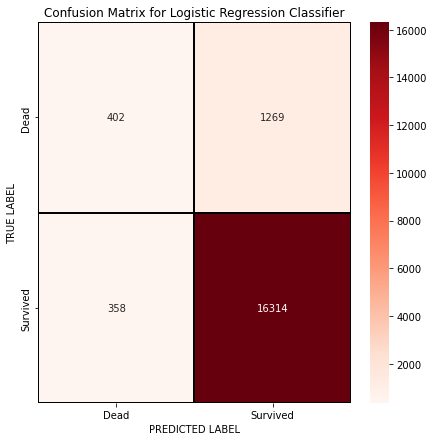

In [127]:
scores_dict = {}

lrc = LogisticRegression(solver="liblinear")
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=lrc, model_name="Logistic Regression Classifier", experiment="best_params",show_report=True)

## Decision Tree Classifier

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.91      0.92     16672
           1       0.30      0.37      0.33      1671

    accuracy                           0.86     18343
   macro avg       0.62      0.64      0.63     18343
weighted avg       0.88      0.86      0.87     18343



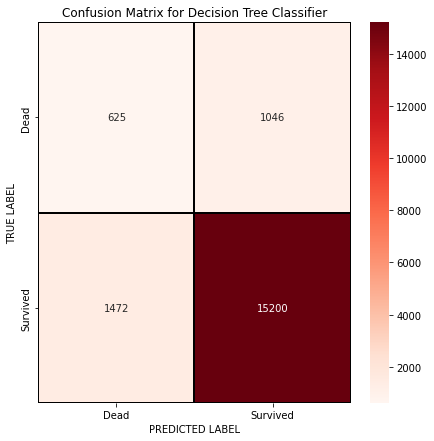

In [128]:
dtc = DecisionTreeClassifier(criterion='gini')
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=dtc, model_name="Decision Tree Classifier", experiment="best_params",show_report=True)

## Gaussian Naive Bayes Classifier 

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.96      0.77      0.85     16672
           1       0.22      0.65      0.33      1671

    accuracy                           0.76     18343
   macro avg       0.59      0.71      0.59     18343
weighted avg       0.89      0.76      0.80     18343



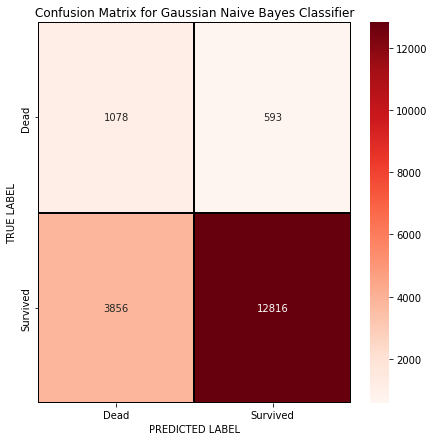

In [129]:
gnb = GaussianNB()
run_classifications(trainX,trainY,testX,testY, 
        model=gnb, model_name="Gaussian Naive Bayes Classifier", experiment="best_params",show_report=True)

## Random Forest Classifier

Random Forest Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.99      0.96     16672
           1       0.69      0.26      0.38      1671

    accuracy                           0.92     18343
   macro avg       0.81      0.63      0.67     18343
weighted avg       0.91      0.92      0.91     18343



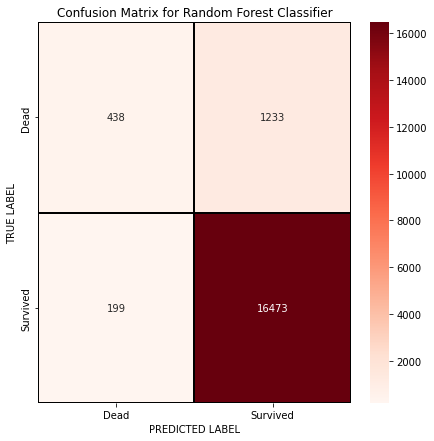

In [130]:
rfc = RandomForestClassifier(criterion='gini',min_samples_split=2,max_depth=None, n_estimators=100)
run_classifications(trainX,trainY,testX,testY,
        model=rfc, model_name="Random Forest Classifier", experiment="best_params",show_report=True)

## AdaBoost Classifier

AdaBoost Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.97      0.95     16672
           1       0.51      0.30      0.38      1671

    accuracy                           0.91     18343
   macro avg       0.72      0.64      0.67     18343
weighted avg       0.89      0.91      0.90     18343



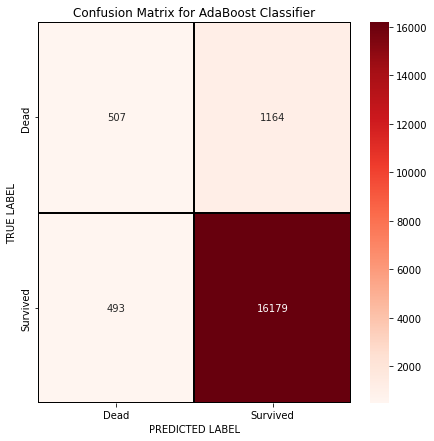

In [131]:
decTree = DecisionTreeClassifier(max_depth=None)
abc = AdaBoostClassifier(base_estimator = decTree, learning_rate=2)
run_classifications(trainX,trainY,testX,testY, model=abc, model_name="AdaBoost Classifier", experiment="best_params",show_report=True)

## Linear Discriminant Analysis

Linear Discriminant Analysis report: 

               precision    recall  f1-score   support

           0       0.94      0.94      0.94     16672
           1       0.40      0.38      0.39      1671

    accuracy                           0.89     18343
   macro avg       0.67      0.66      0.66     18343
weighted avg       0.89      0.89      0.89     18343



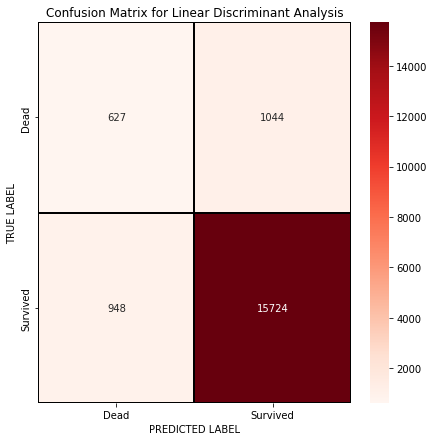

In [132]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
run_classifications(trainX,trainY,testX,testY,
        model=lda, model_name="Linear Discriminant Analysis", experiment="best_params",show_report=True)

## Support Vector Machine 

In [133]:
scaler = StandardScaler()

trainX_scaled = pd.DataFrame(scaler.fit_transform(trainX,columns = trainX.columns))
testX_scaled = pd.DataFrame(scaler.transform(testX,columns = testX.columns))

Support Vector Machine report: 

               precision    recall  f1-score   support

           0       0.93      0.96      0.94     16672
           1       0.40      0.29      0.33      1671

    accuracy                           0.90     18343
   macro avg       0.66      0.62      0.64     18343
weighted avg       0.88      0.90      0.89     18343



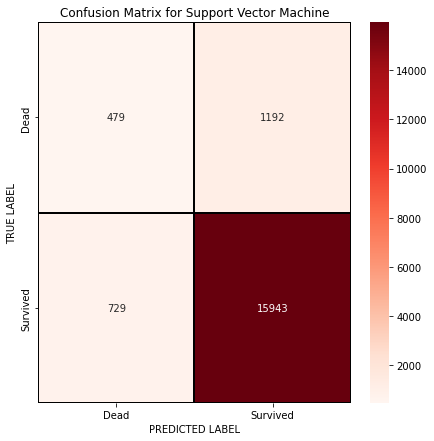

In [134]:
svc = SVC(kernel='poly')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc, model_name='Support Vector Machine', experiment="best_params",show_report=True)

## KNeighbors Classifier

KNeighbors Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.98      0.95     16672
           1       0.39      0.13      0.20      1671

    accuracy                           0.90     18343
   macro avg       0.66      0.56      0.57     18343
weighted avg       0.87      0.90      0.88     18343



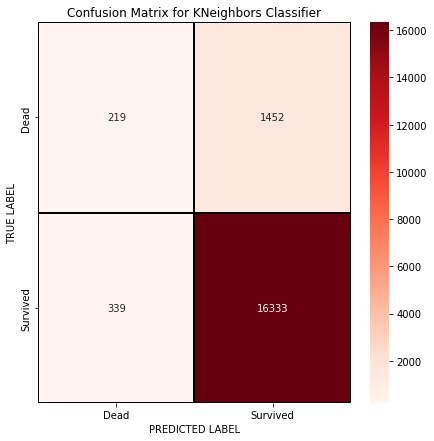

In [135]:
knc = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
run_classifications(trainX,trainY,testX,testY,
        model=knc, model_name="KNeighbors Classifier", experiment="best_params",show_report=True)

## MLP Classifier

MLP Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.96      0.95     16672
           1       0.44      0.31      0.36      1671

    accuracy                           0.90     18343
   macro avg       0.69      0.63      0.65     18343
weighted avg       0.89      0.90      0.89     18343



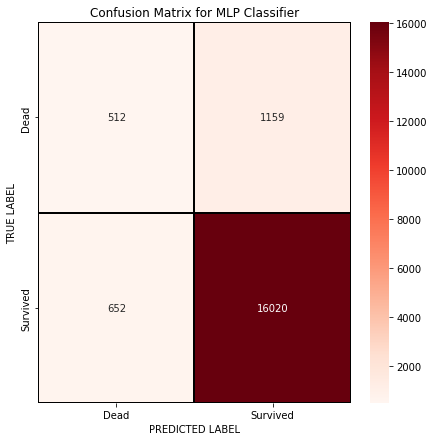

In [136]:
mlp = MLPClassifier(hidden_layer_sizes=500, alpha=0.05, max_iter=1000, solver='sgd', learning_rate_init=0.0001)
run_classifications(trainX,trainY,testX,testY,
        model=mlp, model_name="MLP Classifier", experiment="best_params",show_report=True)

Come atteso, le reti neruali offrono ottimi risultati se utilizzate su grandi quantità di dati e sopratutto se addestrate continuamente nel tempo. Nel nostro caso, non avendo a disposizione una capacità computazionale elevata, abbiam dovuto limitare il numero di volte cui ogni data point viene utilizzato, `max_iter`, non giungendo dunque ad una convergenza assoluta sulla classificazione.  

Inoltre, il numero di *hidden layer* e la loro dimensione dipende anche dalle caratteristiche della macchina che effettua l'addestramento. Ciò non ci ha permesso di aumentare eccessivamente la dimensione della rete, poichè avrebbe richiesto un tempo di addestramento troppo elevato. 

# Confronto e Conclusioni

Riportiamo in forma compatta tutti gli score ottenuti dai classificatori analizzati in precedenza, in modo da confrontarne i risultati.

In [137]:
final_scores = pd.DataFrame(scores_dict).T
final_scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.528947  0.911301     0.240575  0.759425   
Decision Tree Classifier         0.298045  0.862727     0.374028  0.625972   
Gaussian Naive Bayes Classifier  0.218484  0.757455     0.645123  0.354877   
Random Forest Classifier         0.687598  0.921932     0.262118  0.737882   
AdaBoost Classifier                 0.507  0.909666     0.303411  0.696589   
Linear Discriminant Analysis     0.398095  0.891403     0.375224  0.624776   
Support Vector Machine           0.396523  0.895273     0.286655  0.713345   
KNeighbors Classifier            0.392473  0.902361     0.131059  0.868941   
MLP Classifier                   0.439863   0.90127     0.306403  0.693597   

                                      TNR       FPR   experiment  
Logistic Regression Classifier   0.978527  0.021473  best_params  
Decision Tree Classifier         0.911708  0.088292  best_params  
Gaussian Naive Bayes Classifier  0.768714  0.231286  best_params  
Random Forest Classifier         0.988064  0.011936  best_params  
AdaBoost Classifier              0.970429  0.029571  best_params  
Linear Discriminant Analysis     0.943138  0.056862  best_params  
Support Vector Machine           0.956274  0.043726  best_params  
KNeighbors Classifier            0.979667  0.020333  best_params  
MLP Classifier                   0.960893  0.039107  best_params

Nella tabelle in alto è possibile vedere un confronto dei risultati ottenuti dai diversi classificatori analizzati precedentemente.  
Per individuare il miglior classificatore tra quelli proposti è necessario stabilire un *trade-off* tra *recall* e *False Positive Rate*. Infatti, nel contesto a cui si applica tale studio, risulta fondamentale evitare di sovrastimare la probabilità di sopravvivenza di un paziente, in quanto potrebbe conseguirne un trattamento medico non adeguato alla gravità della situazione.  

Introdotta tale precisazione, possiamo identificare in **Gaussian Naive Bayes** il miglior classificatore in quanto presenta la più alta *recall* $\approx 64.5 \%$ (quindi il più basso tasso di  *Falsi Negativi* $ \approx 35.5 \%$) a fronte di un numero accettabile di *Falsi Positivi* individuati ($ \approx 0.23 \% $).

Analizzando gli score della **Linear Discriminant Analysis**,si osserva un valore molto più basso di *recall* ($\approx 37.5 \%$), ma anche un errore minimo in termini di *FPR* ($\approx 5% \%$) ed una accuracy nettamente maggiore ($ \approx 89\%$). Per questo *LDA* rappresenta una valida alternativa a *Naive bayes*, mantenendo un buon *tradeoff tra TPR e FPR*

Il modello che riesce ad ottenere nella sua classificazione il più alto numero di *True Negative* è *Random Forest* ($\approx 99\%$). Tuttavia, tale comportamento è dovuto al fatto che tende a predire più frequentemente un paziente come `survived`, come possiamo vedere anche dell'elevata percentuale di istanze misclassificate come negative, *FNR* $ \approx 74%$.

È possibile effettuare un'analisi analoga sul comportamento della *Multilayer Perceptron* la quale, non avendo a disposizione una grande quantità di dati su cui addestrarsi, e venendo eseguita per un breve tempo a causa della capacità computazionale della macchina, tende anch'essa a sovrastimare le istanze negative presenti nel testing set, raggiungendo una recall di solo $0.30$.  

In termini di *recall* il peggior classificatore risulta essere *KNeighbors Classifier* probabilmente perchè il dataset non è facilmente raggruppabile in cluster rispetto al target.

Infine, tutti gli altri classificatori presentano delle prestazioni simili tra loro: tendono a dichiarare un'istanza come negativa, risultando quindi non adatti al nostro scenario.

#### Prestazioni con SMOTE

Eseguiamo i classificatori con le migliori prestazioni anche utilizzando un dataset bilanciato tramite la tecnica di resampling **SMOTE**

In [138]:
scores_dict = {}

run_classifications(trainX_smote,trainY_smote,testX,testY, 
        model=lrc, model_name="Logistic Regression Classifier", experiment="SMOTE")

run_classifications(trainX_smote,trainY_smote,testX,testY,
        model=rfc, model_name="Random Forest Classifier", experiment="SMOTE")

run_classifications(trainX_smote,trainY_smote,testX,testY,
        model=gnb, model_name="Gaussian Naive Bayes Classifier", experiment="SMOTE")

run_classifications(trainX_smote,trainY_smote,testX,testY,
        model=lda, model_name="Linear Discriminant Analysis", experiment="SMOTE")

run_classifications(trainX_smote,trainY_smote,testX,testY,
        model=dtc, model_name="Decision Tree Classifier", experiment="SMOTE", show_report=False)

Come accennato durante la *Feature Engineering*, tramite **SMOTE** si ottengono risultati migliori in termini di *recall* su alcuni classificatori; questo perché al modello verrano mostrate molte più istanze positive e di conseguenza sarà più probabile che una qualsiasi istanza venga classificata come tale.

In [139]:
smote_scores = pd.DataFrame(scores_dict).T
smote_scores

Precision  Accuracy TPR (recall)       FNR  \
Logistic Regression Classifier   0.253903  0.778281     0.739677  0.260323   
Random Forest Classifier         0.541596  0.914245     0.381807  0.618193   
Gaussian Naive Bayes Classifier  0.227247  0.753694     0.709755  0.290245   
Linear Discriminant Analysis     0.256251  0.780298     0.742071  0.257929   
Decision Tree Classifier         0.269246  0.845827      0.40395   0.59605   

                                      TNR       FPR experiment  
Logistic Regression Classifier    0.78215   0.21785      SMOTE  
Random Forest Classifier          0.96761   0.03239      SMOTE  
Gaussian Naive Bayes Classifier  0.758097  0.241903      SMOTE  
Linear Discriminant Analysis     0.784129  0.215871      SMOTE  
Decision Tree Classifier         0.890115  0.109885      SMOTE

In questo caso il miglior classificatore risulta essere **Linear Discriminant Analysis** che presenta score nettamente migliori su tutti gli indici rispetto a Naive Bayes. Comparando LDA nel caso originale e con SMOTE si osserva un decremento della `precision` e della `accuracy`, ma si ha un perfetto bilanciamento nella classificazione delle istanze positive e negative ($TPR \approx 0.782, TNR \approx 0.784$) 

![](.img/last-comp.png)

In definitiva, risulta preferibile utilizzare sul dataset in analisi il classificatore **LDA** utilizzando **SMOTE** come tecnica di sampling.

Tuttavia, bisogna tenere conto che lo scenario propone dataset molto sbilanciati, su cui vengono inserite $\frac{6}{7}$ di istanze artificiali. Essendo quindi elevato il numero di istanze sintetiche *sintetiche*(circa pari alla dimensione del dataset), si introduce un rumore significativo nei dati, oltre al fatto che verrà impiegato un maggiore tempo di addestramento non trascurabile.